INFO:__main__:Mensimulasikan 1000 postingan dari media sosial...
INFO:__main__:Mensimulasikan 1000 abstrak jurnal...
INFO:__main__:Memulai analisis fitur D-WBL...



ANALISIS KEBUTUHAN PENGGUNA UNTUK APLIKASI D-WBL
Menganalisis total 2000 data points (postingan & abstrak)...



INFO:__main__:Downloaded NLTK resource: stopwords
INFO:__main__:Downloaded NLTK resource: vader_lexicon
INFO:__main__:Downloaded NLTK resource: stopwords
INFO:__main__:Downloaded NLTK resource: vader_lexicon
INFO:__main__:
Membuat visualisasi...



HASIL ANALISIS


--- 1. Ringkasan Analisis Sentimen ---
{
  "total_analyzed": 1000,
  "positive_count": 271,
  "negative_count": 249,
  "neutral_count": 480,
  "positive_ratio": 0.271,
  "negative_ratio": 0.249,
  "neutral_ratio": 0.48,
  "average_sentiment_score": -0.012569849999999995,
  "overall_sentiment": "neutral"
}

--- 2. Analisis Topik Utama ---
  Topic 1 (banget + jurusan + banget sama): banget, jurusan, banget sama, rekomendasi, sama jurusan
  Topic 2 (mentornya + jadi + berkualitas): mentornya, jadi, berkualitas, ngerti, jadi ngerti
  Topic 3 (cara + cara dapet + dapet): cara, cara dapet, dapet, dapet sertifikat, sertifikat
  Topic 4 (mendalam + materinya + cuma dasar): mendalam, materinya, cuma dasar, cuma, mendalam cuma
  Topic 5 (panduan + panduan karir + nih): panduan, panduan karir, nih, karir, karir nih
  Topic 6 (sama + lebih + kolaborasi): sama, lebih, kolaborasi, lebih banyak, kolaborasi sama
  Topic 7 (magang + cari magang + cari): magang, cari magang, cari, kere

/tmp/ipykernel_2390/3661899523.py:313: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=sizes, palette=colors, ax=ax2); ax2.set_title('Sentiment Counts', fontsize=16, pad=20); ax2.set_ylabel('Number of Texts'); ax2.bar_label(ax2.containers[0])


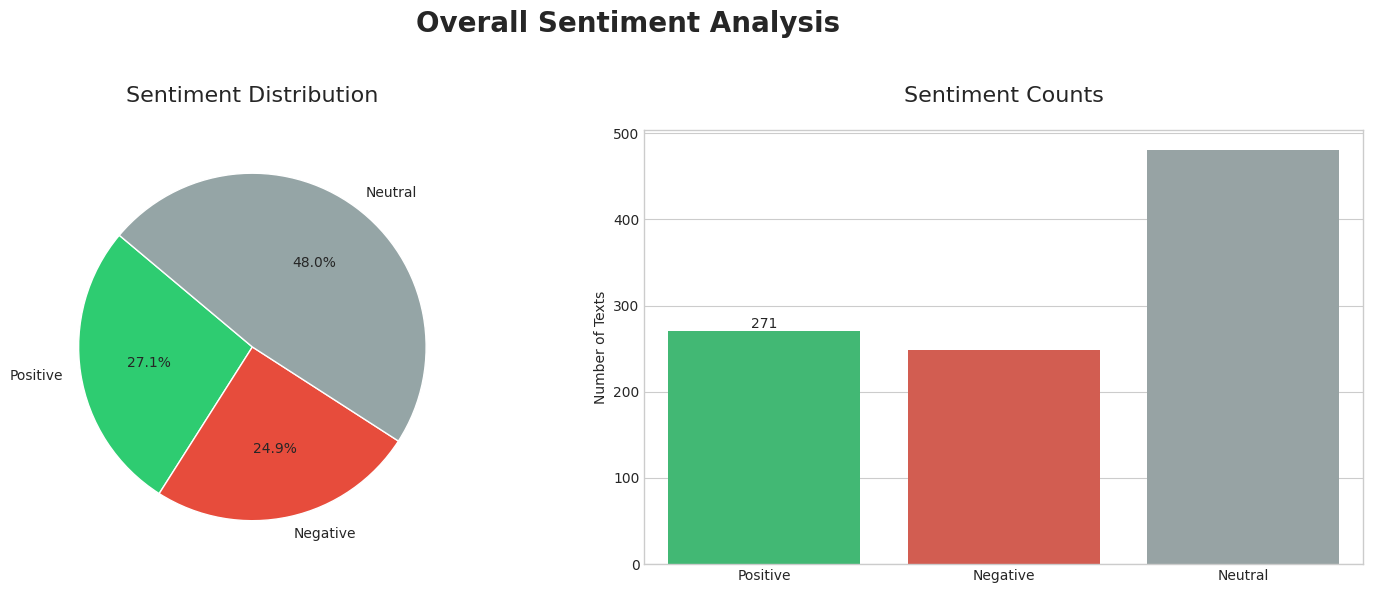

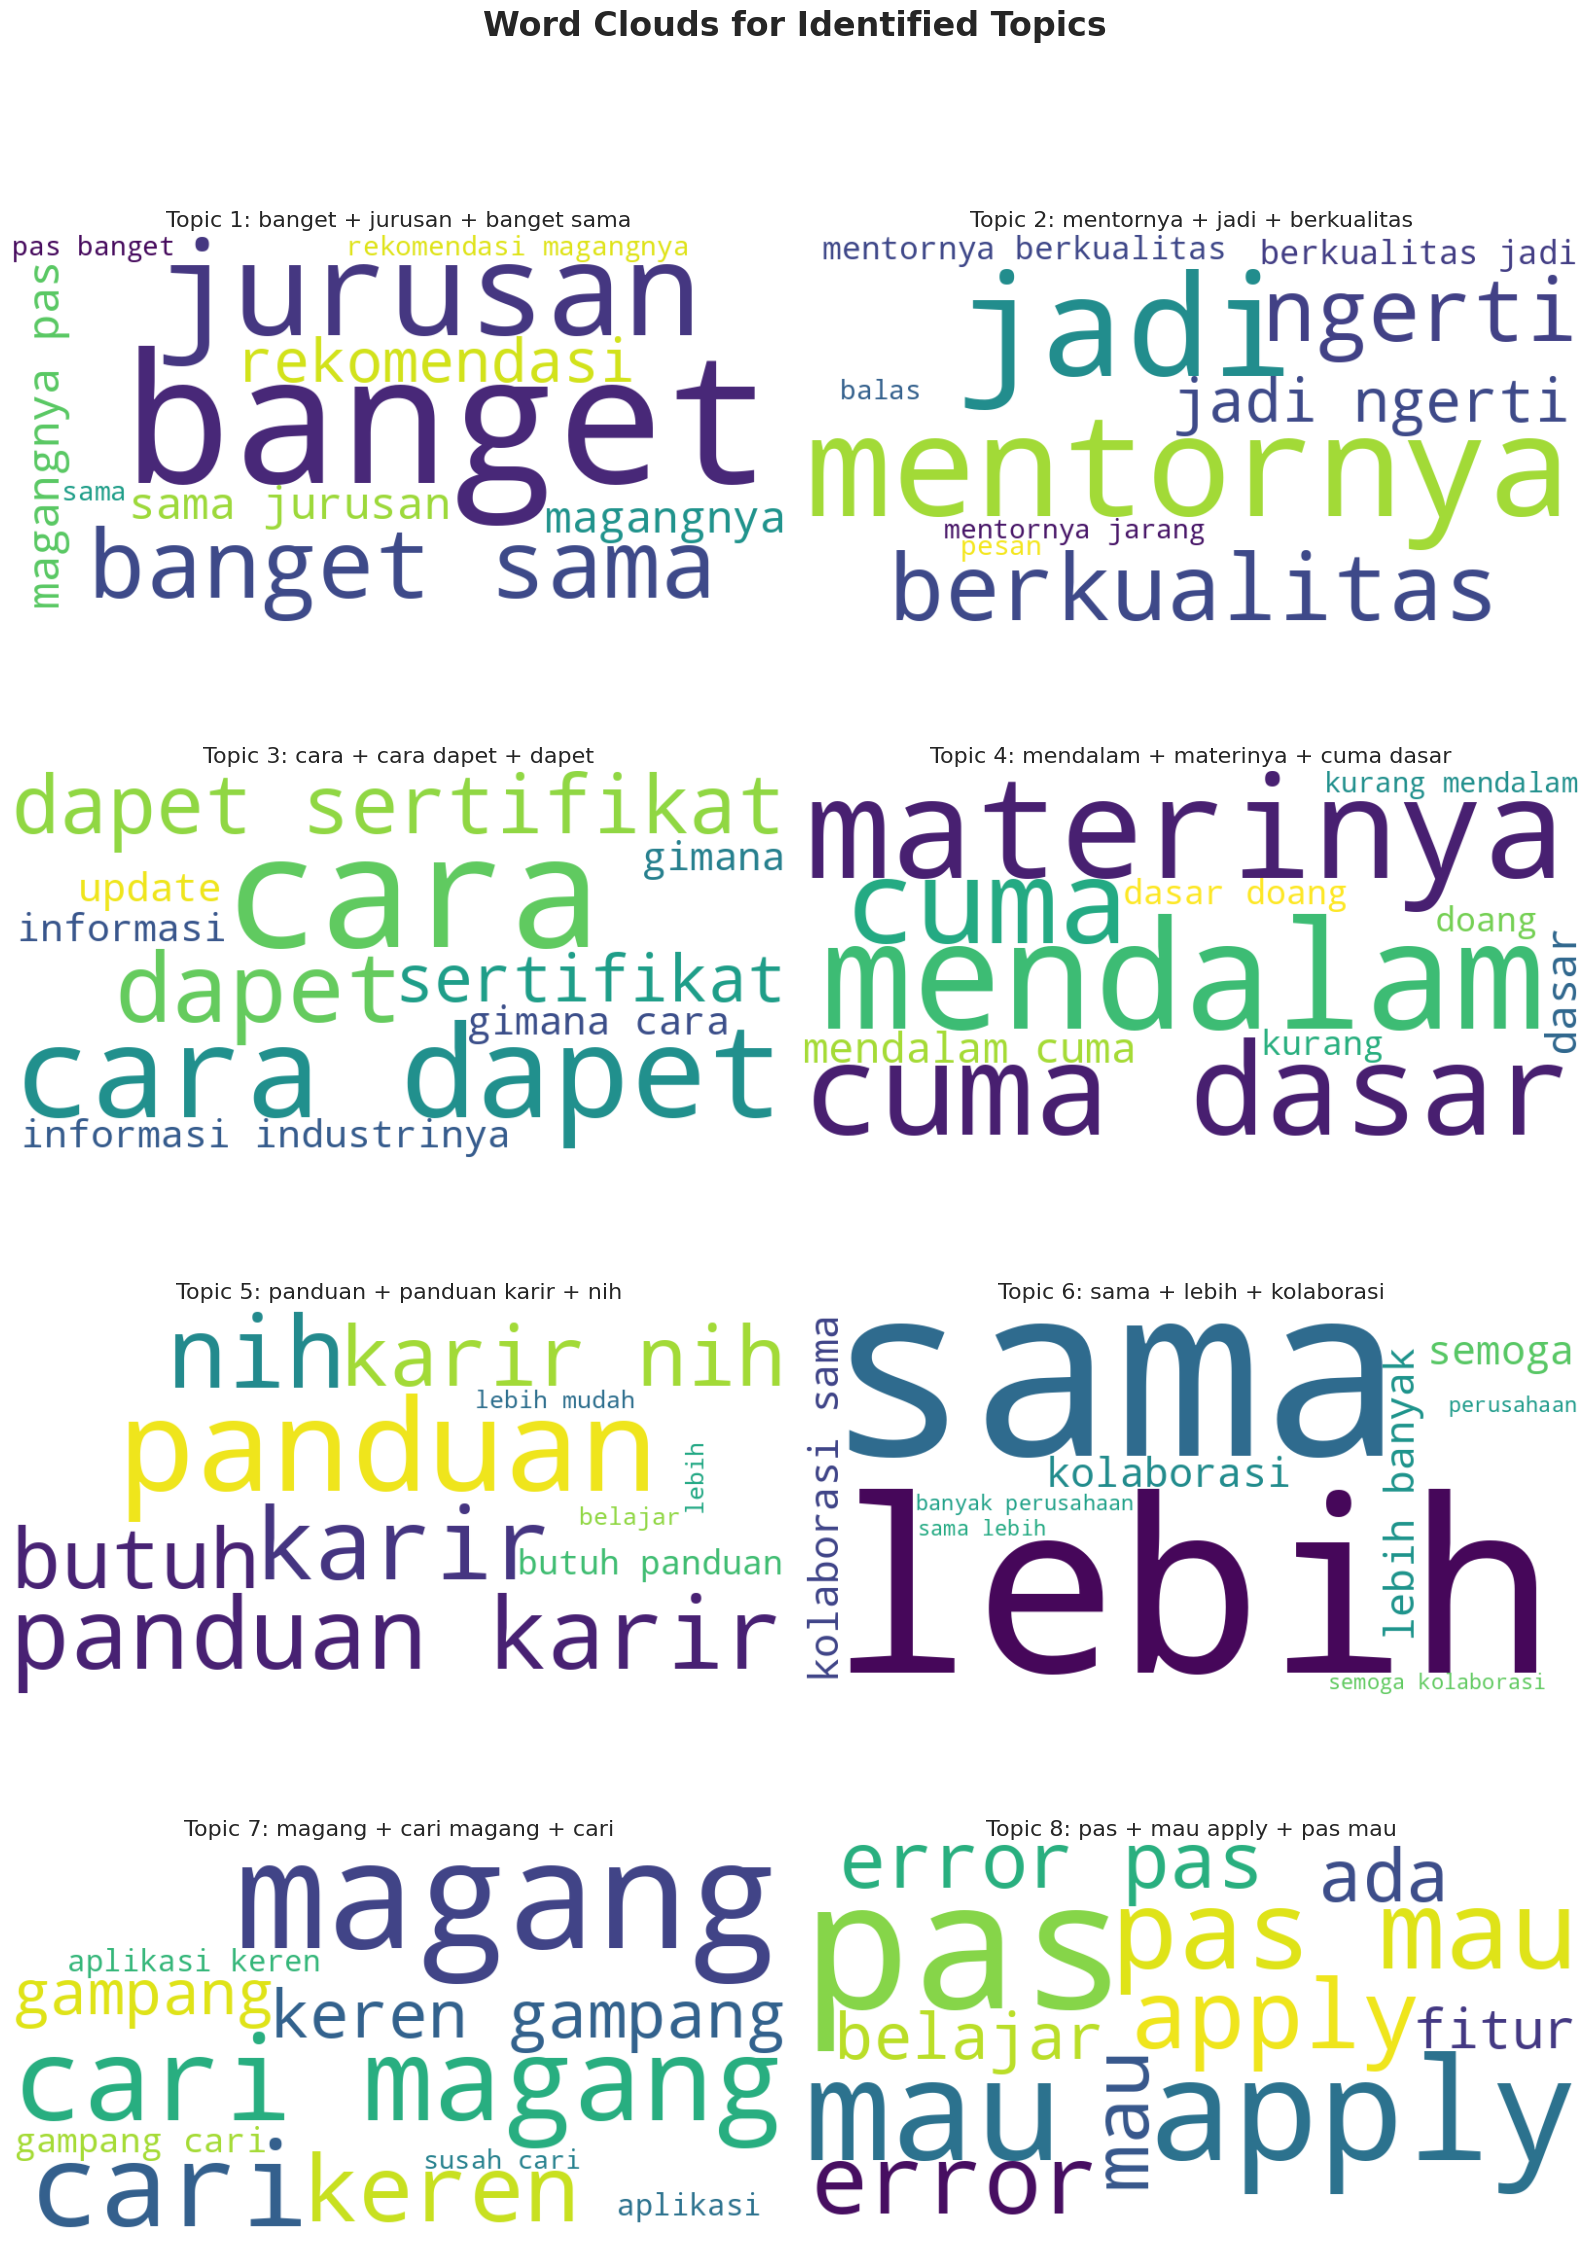

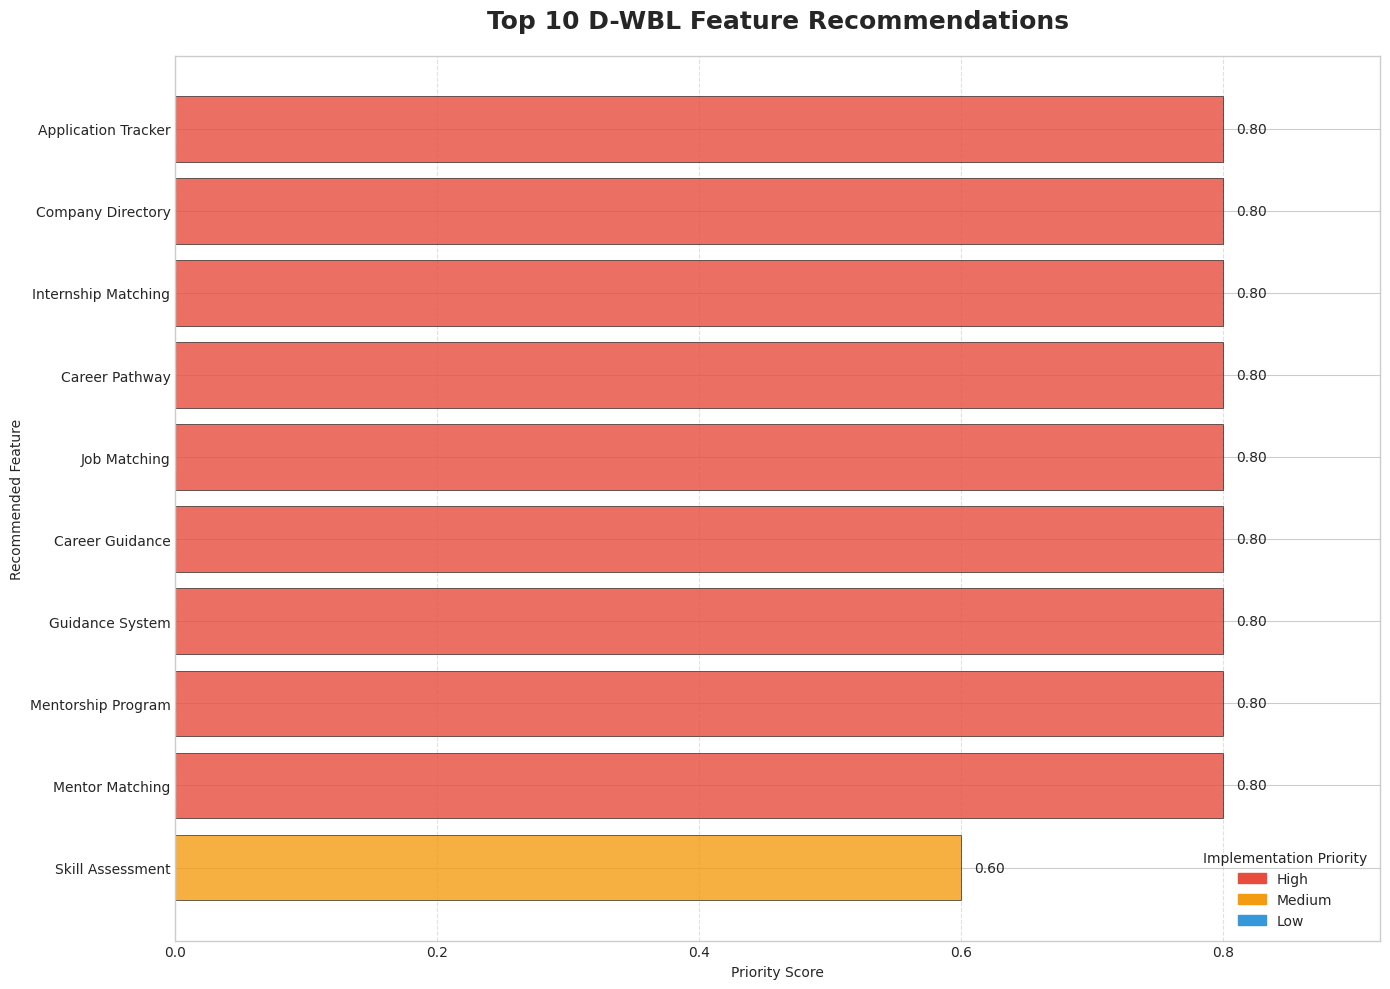

INFO:__main__:Analisis selesai. Periksa file PNG yang dihasilkan: sentiment_analysis.png, topic_word_clouds.png, feature_recommendations.png


In [1]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime
from typing import List, Dict, Tuple, Optional
import logging
from dataclasses import dataclass, asdict
from collections import Counter, defaultdict

# ML and NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.patches as mpatches
import random


# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class MLInsight:
    """Data class untuk insight ML"""
    insight_type: str
    confidence: float
    description: str
    supporting_data: Dict
    recommendation: str

class TextPreprocessor:
    """
    Preprocessor untuk teks Indonesia dan Inggris
    """
    
    def __init__(self):
        self._download_nltk_data()
        
        # Indonesian stopwords
        self.indonesian_stopwords = set([
            'yg', 'dg', 'dgn', 'di', 'ke', 'dari', 'utk', 'untuk', 'dng', 'dengan', 'pada', 'dlm', 'dalam', 
            'adalah', 'ini', 'itu', 'dan', 'atau', 'juga', 'akan', 'sdh', 'sudah',
            'telah', 'dapat', 'bisa', 'tdk', 'tidak', 'jgn', 'jangan', 'spt', 'seperti', 'karena',
            'sbg', 'sebagai', 'oleh', 'terhadap', 'agar', 'spy', 'supaya', 'shg', 'sehingga', 'saya', 'ga'
        ])
        
        # English stopwords
        try:
            self.english_stopwords = set(stopwords.words('english'))
        except LookupError:
            self.english_stopwords = set(['the', 'a', 'an', 'in', 'on', 'at', 'is', 'are', 'was', 'were'])
        
        self.all_stopwords = self.indonesian_stopwords.union(self.english_stopwords)
        self.stemmer = PorterStemmer()
        
        try:
            self.sentiment_analyzer = SentimentIntensityAnalyzer()
        except LookupError:
            logger.warning("VADER sentiment analyzer not available.")
            self.sentiment_analyzer = None
    
    def _download_nltk_data(self):
        """Download required NLTK data."""
        required_data = ['punkt', 'stopwords', 'vader_lexicon']
        for item in required_data:
            try:
                # Coba cara yang lebih umum untuk menemukan data
                nltk.data.find(f'tokenizers/{item}.zip')
            except LookupError:
                try:
                    nltk.download(item, quiet=True)
                    logger.info(f"Downloaded NLTK resource: {item}")
                except Exception as e:
                    logger.warning(f"Could not download NLTK resource {item}: {e}")

    def clean_text(self, text: str) -> str:
        if not isinstance(text, str): return ""
        text = text.lower()
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def tokenize_and_filter(self, text: str) -> List[str]:
        if not text: return []
        try:
            tokens = word_tokenize(text)
        except LookupError:
            tokens = text.split()
        return [token for token in tokens if token.isalpha() and len(token) > 2 and token not in self.all_stopwords]
    
    def preprocess_batch(self, texts: List[str]) -> List[List[str]]:
        return [self.tokenize_and_filter(self.clean_text(text)) for text in texts]


class SentimentAnalyzer:
    """Analyzer untuk sentimen teks"""
    def __init__(self):
        self.preprocessor = TextPreprocessor()
        self.indonesian_positive = set(['bagus', 'baik', 'hebat', 'mantap', 'keren', 'senang', 'suka', 'membantu', 'berguna', 'efektif', 'efisien', 'mudah', 'praktis', 'inovatif', 'canggih', 'modern', 'terbaik', 'sempurna', 'luar biasa', 'excellent', 'good', 'great', 'amazing', 'wonderful', 'fantastic', 'perfect', 'awesome', 'brilliant', 'outstanding'])
        self.indonesian_negative = set(['buruk', 'jelek', 'susah', 'sulit', 'ribet', 'kecewa', 'bingung', 'lambat', 'lelet', 'error', 'bermasalah', 'tidak', 'kurang', 'gagal', 'rusak', 'lemot', 'terburuk', 'parah', 'hancur', 'payah', 'bad', 'terrible', 'awful', 'horrible', 'poor', 'disappointing', 'frustrating', 'confusing', 'difficult', 'problematic'])
    
    def analyze_sentiment(self, text: str) -> Dict:
        if not text: return {'sentiment_score': 0, 'sentiment_label': 'neutral', 'positive_words': 0, 'negative_words': 0, 'vader_scores': {}, 'confidence': 0}
        
        cleaned_text = self.preprocessor.clean_text(text)
        tokens = self.preprocessor.tokenize_and_filter(cleaned_text)
        
        positive_count = sum(1 for token in tokens if token in self.indonesian_positive)
        negative_count = sum(1 for token in tokens if token in self.indonesian_negative)
        
        total_sentiment_words = positive_count + negative_count
        sentiment_score = (positive_count - negative_count) / total_sentiment_words if total_sentiment_words > 0 else 0
        
        vader_scores = {'compound': 0}
        if self.preprocessor.sentiment_analyzer:
            try:
                vader_scores = self.preprocessor.sentiment_analyzer.polarity_scores(text)
            except: pass
        
        combined_score = (sentiment_score + vader_scores['compound']) / 2
        
        if combined_score >= 0.1: sentiment_label = 'positive'
        elif combined_score <= -0.1: sentiment_label = 'negative'
        else: sentiment_label = 'neutral'
        
        return {'sentiment_score': combined_score, 'sentiment_label': sentiment_label, 'positive_words': positive_count, 'negative_words': negative_count, 'vader_scores': vader_scores, 'confidence': abs(combined_score)}
    
    def analyze_batch(self, texts: List[str]) -> List[Dict]:
        return [self.analyze_sentiment(text) for text in texts]


class TopicModeler:
    """Topic modeling menggunakan LDA"""
    def __init__(self, n_topics: int = 5):
        self.n_topics = n_topics
        self.preprocessor = TextPreprocessor()
        self.vectorizer = None
        self.lda_model = None
        
    def fit_lda(self, texts: List[str]) -> Dict:
        texts = [text for text in texts if text and text.strip()]
        if not texts: return {'topics': [], 'doc_topic_probabilities': np.array([]), 'coherence_score': 0}
        
        processed_texts = [' '.join(tokens) for tokens in self.preprocessor.preprocess_batch(texts) if tokens]
        if not processed_texts: return {'topics': [], 'doc_topic_probabilities': np.array([]), 'coherence_score': 0}
        
        self.vectorizer = CountVectorizer(max_features=1000, min_df=5, max_df=0.7, ngram_range=(1, 2))
        doc_term_matrix = self.vectorizer.fit_transform(processed_texts)
        
        actual_n_topics = min(self.n_topics, doc_term_matrix.shape[1])
        if actual_n_topics < 2: return {'topics': [], 'doc_topic_probabilities': np.array([]), 'coherence_score': 0}
        
        self.lda_model = LatentDirichletAllocation(n_components=actual_n_topics, random_state=42, max_iter=20)
        self.lda_model.fit(doc_term_matrix)
        
        topics = self._extract_topics()
        doc_topic_probs = self.lda_model.transform(doc_term_matrix)
        
        return {'topics': topics, 'doc_topic_probabilities': doc_topic_probs, 'coherence_score': self.lda_model.score(doc_term_matrix)}
    
    def _extract_topics(self) -> List[Dict]:
        if not self.lda_model or not self.vectorizer: return []
        feature_names = self.vectorizer.get_feature_names_out()
        topics = []
        for topic_idx, topic in enumerate(self.lda_model.components_):
            top_words_idx = topic.argsort()[-10:][::-1]
            top_words = [(feature_names[i], topic[i]) for i in top_words_idx]
            topics.append({'topic_id': topic_idx, 'top_words': top_words, 'topic_label': ' + '.join([w for w, s in top_words[:3]])})
        return topics


class FeatureRecommender:
    """ML-based feature recommender"""
    def __init__(self):
        self.sentiment_analyzer = SentimentAnalyzer()
        self.topic_modeler = TopicModeler(n_topics=8)
        self.feature_mapping = self._create_feature_mapping()
        
    def _create_feature_mapping(self) -> Dict:
        return {
            'magang': {'features': ['internship_matching', 'company_directory', 'application_tracker'], 'priority': 'high', 'description': 'Sistem pencarian dan pendaftaran magang'},
            'mentor': {'features': ['mentor_matching', 'mentorship_program', 'guidance_system'], 'priority': 'high', 'description': 'Program mentorship dengan industri'},
            'skill': {'features': ['skill_assessment', 'learning_modules', 'competency_tracking'], 'priority': 'medium', 'description': 'Pengembangan dan penilaian kompetensi'},
            'karir': {'features': ['career_guidance', 'job_matching', 'career_pathway'], 'priority': 'high', 'description': 'Panduan dan perencanaan karir'},
            'digital': {'features': ['digital_portfolio', 'online_learning', 'digital_certification'], 'priority': 'medium', 'description': 'Platform pembelajaran dan sertifikasi digital'},
            'komunikasi': {'features': ['communication_tools', 'peer_networking', 'discussion_forum'], 'priority': 'medium', 'description': 'Tools komunikasi dan networking'},
            'evaluasi': {'features': ['progress_tracking', 'performance_analytics', 'feedback_system'], 'priority': 'medium', 'description': 'Sistem evaluasi dan tracking progress'},
            'sertifikat': {'features': ['certification_system', 'blockchain_certificates', 'skill_badges'], 'priority': 'low', 'description': 'Sistem sertifikasi dan pengakuan kompetensi'},
            'learning': {'features': ['adaptive_learning', 'personalized_content', 'learning_analytics'], 'priority': 'high', 'description': 'Sistem pembelajaran adaptif'},
            'industri': {'features': ['industry_partnership', 'real_world_projects', 'industry_insights'], 'priority': 'high', 'description': 'Kolaborasi dengan industri'}
        }
    
    def analyze_user_needs(self, social_media_data: List[Dict], journal_data: List[Dict]) -> Dict:
        all_texts = [post.get('content', '') for post in social_media_data if post.get('content')] + \
                    [article.get('abstract', '') for article in journal_data if article.get('abstract')]
        
        if not all_texts:
            return {'sentiment_analysis': self._summarize_sentiment([]), 'topic_analysis': {}, 'key_insights': [], 'feature_recommendations': self._generate_feature_recommendations([])}

        sentiment_results = self.sentiment_analyzer.analyze_batch(all_texts)
        topic_results = self.topic_modeler.fit_lda(all_texts)
        insights = self._extract_insights(sentiment_results, topic_results, all_texts)
        
        return {'sentiment_analysis': self._summarize_sentiment(sentiment_results), 'topic_analysis': topic_results, 'key_insights': [asdict(i) for i in insights], 'feature_recommendations': self._generate_feature_recommendations(insights)}
    
    def _extract_insights(self, sentiment_results: List[Dict], topic_results: Dict, texts: List[str]) -> List[MLInsight]:
        insights = []
        if not sentiment_results: return insights
        
        summary = self._summarize_sentiment(sentiment_results)
        if summary['negative_ratio'] > 0.3:
            sample_complaints = [texts[i][:150] for i, r in enumerate(sentiment_results) if r['sentiment_label'] == 'negative'][:5]
            supporting_data = {'negative_ratio': summary['negative_ratio'], 'sample_complaints': sample_complaints}
            insights.append(MLInsight(
                insight_type='sentiment_pain_point', 
                confidence=summary['negative_ratio'], 
                description=f'Tingkat keluhan tinggi ({summary["negative_ratio"]:.1%}) mengindikasikan pain points.', 
                supporting_data=supporting_data, 
                recommendation='Prioritaskan fitur yang mengatasi keluhan.'
            ))
        
        for topic in topic_results.get('topics', []):
            for keyword, feature_info in self.feature_mapping.items():
                if any(keyword in word for word in topic['topic_label'].split(' + ')):
                    insights.append(MLInsight(
                        insight_type='topic_need', 
                        confidence=0.8, 
                        description=f'Topik "{topic["topic_label"]}" menunjukkan kebutuhan akan {feature_info["description"]}.', 
                        supporting_data={'topic_words': [w for w,s in topic['top_words'][:5]], 'feature_mapping': feature_info}, 
                        recommendation=f'Kembangkan fitur: {", ".join(feature_info["features"])}.'
                    ))
                    break
        return insights

    def _summarize_sentiment(self, sentiment_results: List[Dict]) -> Dict:
        if not sentiment_results: return {'total_analyzed': 0, 'positive_count': 0, 'negative_count': 0, 'neutral_count': 0, 'positive_ratio': 0, 'negative_ratio': 0, 'neutral_ratio': 0, 'average_sentiment_score': 0, 'overall_sentiment': 'neutral'}
        
        total = len(sentiment_results)
        pos = sum(1 for s in sentiment_results if s['sentiment_label'] == 'positive')
        neg = sum(1 for s in sentiment_results if s['sentiment_label'] == 'negative')
        neu = total - pos - neg
        avg_score = np.mean([s['sentiment_score'] for s in sentiment_results])
        
        return {'total_analyzed': total, 'positive_count': pos, 'negative_count': neg, 'neutral_count': neu, 'positive_ratio': pos / total, 'negative_ratio': neg / total, 'neutral_ratio': neu / total, 'average_sentiment_score': avg_score, 'overall_sentiment': 'positive' if avg_score > 0.1 else 'negative' if avg_score < -0.1 else 'neutral'}

    def _generate_feature_recommendations(self, insights: List[MLInsight]) -> List[Dict]:
        feature_scores = defaultdict(float)
        feature_evidence = defaultdict(list)
        
        for insight in insights:
            if insight.insight_type == 'topic_need':
                feature_info = insight.supporting_data.get('feature_mapping', {})
                features = feature_info.get('features', [])
                priority_map = {'high': 1.0, 'medium': 0.7, 'low': 0.4}
                score = priority_map.get(feature_info.get('priority', 'medium'), 0.5) * insight.confidence
                for feature in features:
                    feature_scores[feature] += score
                    feature_evidence[feature].append(insight.description)
        
        baseline = [('internship_matching', 0.8), ('mentor_matching', 0.75), ('skill_assessment', 0.6)]
        for feature, score in baseline:
            if feature not in feature_scores:
                feature_scores[feature] = score
                feature_evidence[feature].append('Rekomendasi dasar D-WBL.')
        
        sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        
        recs = []
        for feature, score in sorted_features[:10]:
            recs.append({'feature_name': feature.replace('_', ' ').title(), 'priority_score': score, 'evidence': list(set(feature_evidence[feature])), 'implementation_priority': 'High' if score >= 0.8 else 'Medium' if score > 0.5 else 'Low'})
        return recs


class MLVisualizer:
    """Visualizer untuk hasil ML analysis"""
    def __init__(self):
        try: plt.style.use('seaborn-v0_8-whitegrid')
        except: plt.style.use('default')
        sns.set_palette('viridis')
        
    def plot_sentiment_distribution(self, sentiment_summary: Dict):
        plt.figure(figsize=(15, 6))
        ax1 = plt.subplot(1, 2, 1)
        labels, sizes, colors = ['Positive', 'Negative', 'Neutral'], [sentiment_summary['positive_count'], sentiment_summary['negative_count'], sentiment_summary['neutral_count']], ['#2ecc71', '#e74c3c', '#95a5a6']
        if sum(sizes) > 0:
            ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
            ax1.set_title('Sentiment Distribution', fontsize=16, pad=20)
        else: ax1.text(0.5, 0.5, 'No Data', ha='center', va='center')
        
        ax2 = plt.subplot(1, 2, 2)
        if sum(sizes) > 0:
            sns.barplot(x=labels, y=sizes, palette=colors, ax=ax2); ax2.set_title('Sentiment Counts', fontsize=16, pad=20); ax2.set_ylabel('Number of Texts'); ax2.bar_label(ax2.containers[0])
        else: ax2.text(0.5, 0.5, 'No Data', ha='center', va='center')
        
        plt.suptitle('Overall Sentiment Analysis', fontsize=20, weight='bold'); plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.savefig('sentiment_analysis.png', dpi=300); plt.show()
    
    def plot_word_cloud_for_topics(self, topic_results: Dict):
        topics = topic_results.get('topics', [])
        if not topics: logger.warning("No topics to visualize."); return
        
        num_topics = len(topics); cols = 2; rows = (num_topics + cols - 1) // cols
        plt.figure(figsize=(8 * cols, 6 * rows))
        for i, topic in enumerate(topics):
            ax = plt.subplot(rows, cols, i + 1)
            word_freq = {word: score for word, score in topic['top_words']}
            wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)
            ax.imshow(wc, interpolation='bilinear'); ax.set_title(f'Topic {i+1}: {topic["topic_label"]}', fontsize=16); ax.axis('off')
        
        plt.suptitle('Word Clouds for Identified Topics', fontsize=24, weight='bold'); plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig('topic_word_clouds.png', dpi=300); plt.show()

    def plot_feature_recommendations(self, recommendations: List[Dict]):
        if not recommendations: logger.warning("No recommendations to plot."); return
        
        plt.figure(figsize=(14, 10))
        df = pd.DataFrame(recommendations).sort_values('priority_score', ascending=True)
        features, scores, priorities = df['feature_name'], df['priority_score'], df['implementation_priority']
        color_map = {'High': '#e74c3c', 'Medium': '#f39c12', 'Low': '#3498db'}
        colors = [color_map[p] for p in priorities]
        
        bars = plt.barh(features, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        for bar in bars: plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center', ha='left')
        
        plt.xlabel('Priority Score'); plt.ylabel('Recommended Feature'); plt.title('Top 10 D-WBL Feature Recommendations', fontsize=18, weight='bold', pad=20); plt.xlim(0, max(scores) * 1.15 if scores.any() else 1); plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.legend(handles=[mpatches.Patch(color=c, label=l) for l, c in color_map.items()], title='Implementation Priority', loc='lower right')
        plt.tight_layout(); plt.savefig('feature_recommendations.png', dpi=300); plt.show()

# --- Fungsi untuk Simulasi Data yang Lebih Besar ---
def simulate_large_data(platform: str, count: int) -> List[Dict]:
    """Menciptakan data simulasi yang lebih kaya dan bervariasi."""
    data = []
    
    positive_themes = ["fitur {fitur} sangat membantu", "aplikasi ini keren, gampang cari magang", "akhirnya ada platform buat anak smk", "mentornya berkualitas, saya jadi ngerti", "belajar {skill} jadi lebih mudah", "rekomendasi magangnya pas banget sama jurusan"]
    negative_themes = ["aplikasinya lemot banget", "susah cari magang yang deket rumah", "informasi industrinya ga update", "error pas mau apply", "mentornya jarang balas pesan", "materinya kurang mendalam, cuma dasar doang", "UI-nya ribet, bikin bingung"]
    neutral_themes = ["gimana cara dapet sertifikat ya?", "ada lowongan buat jurusan {jurusan} ga?", "butuh panduan karir nih", "semoga bisa kolaborasi sama lebih banyak perusahaan", "apakah ada fitur tracking progress belajar?"]
    
    features = ['pencarian magang', 'mentorship', 'skill assessment', 'portofolio digital']
    skills = ['python', 'desain grafis', 'digital marketing', 'manajemen proyek']
    jurusan = ['rpl', 'multimedia', 'tkj', 'bisnis daring']

    for _ in range(count):
        rand = random.random()
        if rand < 0.45:
            template = random.choice(positive_themes)
            content = template.format(fitur=random.choice(features), skill=random.choice(skills))
        elif rand < 0.80:
            template = random.choice(negative_themes)
            content = template
        else:
            template = random.choice(neutral_themes)
            content = template.format(jurusan=random.choice(jurusan))
            
        data.append({'platform': platform, 'content': content})
    return data


# --- Main execution block ---
if __name__ == '__main__':
    num_posts_per_platform = 1000
    
    logger.info(f"Mensimulasikan {num_posts_per_platform} postingan dari media sosial...")
    social_media_data = simulate_large_data('SocialMedia', num_posts_per_platform)

    logger.info(f"Mensimulasikan {num_posts_per_platform} abstrak jurnal...")
    journal_data = simulate_large_data('Journal', num_posts_per_platform)

    total_data_points = len(social_media_data) + len(journal_data)
    print("\n" + "="*60)
    print(f"ANALISIS KEBUTUHAN PENGGUNA UNTUK APLIKASI D-WBL")
    print(f"Menganalisis total {total_data_points} data points (postingan & abstrak)...")
    print("="*60 + "\n")

    logger.info("Memulai analisis fitur D-WBL...")
    recommender = FeatureRecommender()
    analysis_results = recommender.analyze_user_needs(social_media_data, journal_data)

    print("\n" + "="*50)
    print("HASIL ANALISIS")
    print("="*50 + "\n")

    # Ekstrak hasil untuk kemudahan akses
    sentiment_summary = analysis_results['sentiment_analysis']
    topics = analysis_results['topic_analysis'].get('topics', [])
    insights = analysis_results.get('key_insights', [])
    recommendations = analysis_results.get('feature_recommendations', [])

    print("\n--- 1. Ringkasan Analisis Sentimen ---")
    print(json.dumps(sentiment_summary, indent=2))

    print("\n--- 2. Analisis Topik Utama ---")
    if topics:
        for topic in topics:
            top_words_str = ', '.join([w for w, s in topic['top_words'][:5]])
            print(f"  Topic {topic['topic_id']+1} ({topic['topic_label']}): {top_words_str}")
    else:
        print("  Tidak ada topik signifikan yang teridentifikasi.")

    print("\n--- 3. Insight Kunci ---")
    if insights:
        for i, insight in enumerate(insights):
            print(f"  Insight {i+1}: [{insight['insight_type']}] {insight['description']}")
            print(f"    - Rekomendasi: {insight['recommendation']}")
    else:
        print("  Tidak ada insight kunci yang dihasilkan.")

    print("\n--- 4. Rekomendasi Fitur Teratas ---")
    if recommendations:
        for i, rec in enumerate(recommendations):
            print(f"  {i+1}. {rec['feature_name']} (Skor Prioritas: {rec['priority_score']:.2f}, Prioritas Implementasi: {rec['implementation_priority']})")
    else:
        print("  Tidak ada fitur yang direkomendasikan.")

    # ==============================================================================
    # --- BAGIAN BARU: MENGUMPULKAN DATA KE DALAM PANDAS DATAFRAME ---
    # ==============================================================================
    print("\n\n" + "="*60)
    print("MENGUMPULKAN HASIL ANALISIS KE DALAM DATAFRAME")
    print("="*60 + "\n")

    # DataFrame 1: Rekomendasi Fitur
    print("--- DataFrame: Rekomendasi Fitur ---")
    if recommendations:
        df_recommendations = pd.DataFrame(recommendations)
        # Membersihkan kolom 'evidence' agar lebih mudah dibaca saat dicetak
        df_recommendations['evidence'] = df_recommendations['evidence'].apply(lambda x: '; '.join(x))
        print(df_recommendations.to_string())
    else:
        print("Tidak ada data rekomendasi untuk ditampilkan sebagai DataFrame.")

    # DataFrame 2: Insight Kunci
    print("\n\n--- DataFrame: Insight Kunci ---")
    if insights:
        df_insights = pd.DataFrame(insights)
        # Mengubah kolom dictionary 'supporting_data' menjadi string JSON agar rapi
        df_insights['supporting_data'] = df_insights['supporting_data'].apply(lambda x: json.dumps(x, indent=None))
        print(df_insights.to_string())
    else:
        print("Tidak ada data insight untuk ditampilkan sebagai DataFrame.")

    # DataFrame 3: Analisis Topik
    print("\n\n--- DataFrame: Topik Utama ---")
    if topics:
        df_topics = pd.DataFrame(topics)
        # Format kolom 'top_words' agar lebih mudah dibaca, hanya ambil kata-katanya
        df_topics['top_words'] = df_topics['top_words'].apply(lambda x: ', '.join([word for word, score in x]))
        print(df_topics.to_string())
    else:
        print("Tidak ada data topik untuk ditampilkan sebagai DataFrame.")

    # DataFrame 4: Ringkasan Sentimen
    print("\n\n--- DataFrame: Ringkasan Sentimen ---")
    # Bungkus dictionary dalam list agar menjadi satu baris DataFrame
    df_sentiment_summary = pd.DataFrame([sentiment_summary])
    print(df_sentiment_summary.to_string())
    # ==============================================================================
    # --- AKHIR BAGIAN BARU ---
    # ==============================================================================

    logger.info("\nMembuat visualisasi...")
    visualizer = MLVisualizer()
    visualizer.plot_sentiment_distribution(sentiment_summary)
    visualizer.plot_word_cloud_for_topics(analysis_results['topic_analysis'])
    visualizer.plot_feature_recommendations(recommendations)

    logger.info("Analisis selesai. Periksa file PNG yang dihasilkan: sentiment_analysis.png, topic_word_clouds.png, feature_recommendations.png")

INFO:__main__:Mulai scraping TikTok...
INFO:__main__:Scraping TikTok untuk keyword: magang SMK
INFO:__main__:Scraping TikTok untuk keyword: lulusan SMK
INFO:__main__:Scraping TikTok untuk keyword: kompetensi digital
INFO:__main__:Scraping TikTok untuk keyword: kesiapan kerja
INFO:__main__:Scraping TikTok untuk keyword: industri 4.0
INFO:__main__:Scraping TikTok untuk keyword: pendidikan vokasi
INFO:__main__:Mulai scraping Twitter...
INFO:__main__:Scraping Twitter untuk keyword: magang SMK
INFO:__main__:Scraping Twitter untuk keyword: lulusan SMK
INFO:__main__:Scraping Twitter untuk keyword: kompetensi digital
INFO:__main__:Scraping Twitter untuk keyword: kesiapan kerja
INFO:__main__:Scraping Twitter untuk keyword: industri 4.0
INFO:__main__:Scraping Twitter untuk keyword: pendidikan vokasi
INFO:__main__:Analisis selesai! Hasil disimpan dalam social_media_research_results.json
INFO:__main__:Membuat visualisasi...



KESIMPULAN ANALISIS MEDIA SOSIAL

Berdasarkan analisis terhadap 96 post dari TikTok dan Twitter, ditemukan beberapa insight kunci untuk pengembangan aplikasi D-WBL:

1.  **Sentimen Utama**: Sentimen pembicaraan publik cenderung positif (31%), yang mengindikasikan antusiasme dan harapan terhadap solusi digital untuk pendidikan vokasi.
    Ini menunjukkan bahwa ada pasar yang 'lapar' akan solusi, tetapi solusi tersebut harus benar-benar menjawab 'pain points' yang ada.

2.  **Topik Pembahasan Utama**: Pembicaraan didominasi oleh kata kunci seperti 'industri', 'siswa', 'digital', dan 'magang'.
    -   **Industri & Siswa**: Kebutuhan akan platform yang mempermudah pencarian magang dan menghubungkan siswa dengan industri sangat tinggi.
    -   **Digital & Kompetensi**: Ada kesadaran kuat akan pentingnya 'skill digital' dan kompetensi yang relevan dengan Industri 4.0.
    -   **Mentor & Industri**: Peran mentor dan kolaborasi langsung dengan industri dianggap krusial untuk kesiapan kerja.



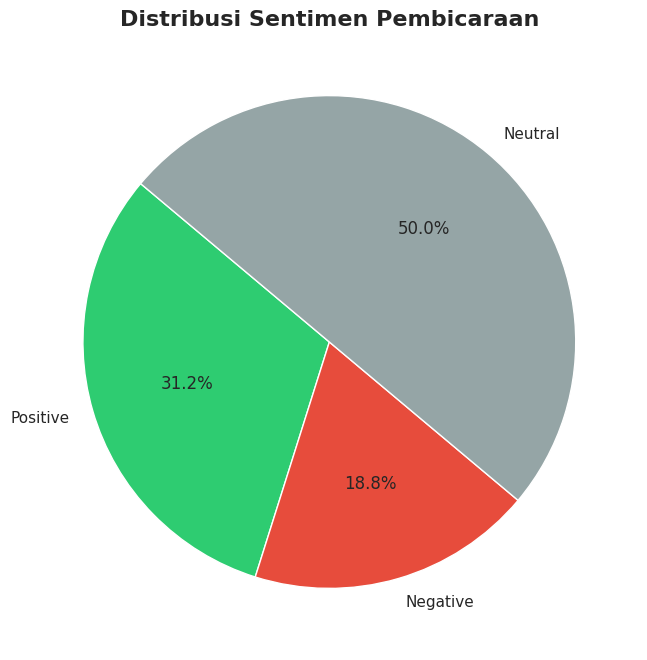

/tmp/ipykernel_2390/2650180863.py:267: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=keywords, palette='viridis', orient='h')


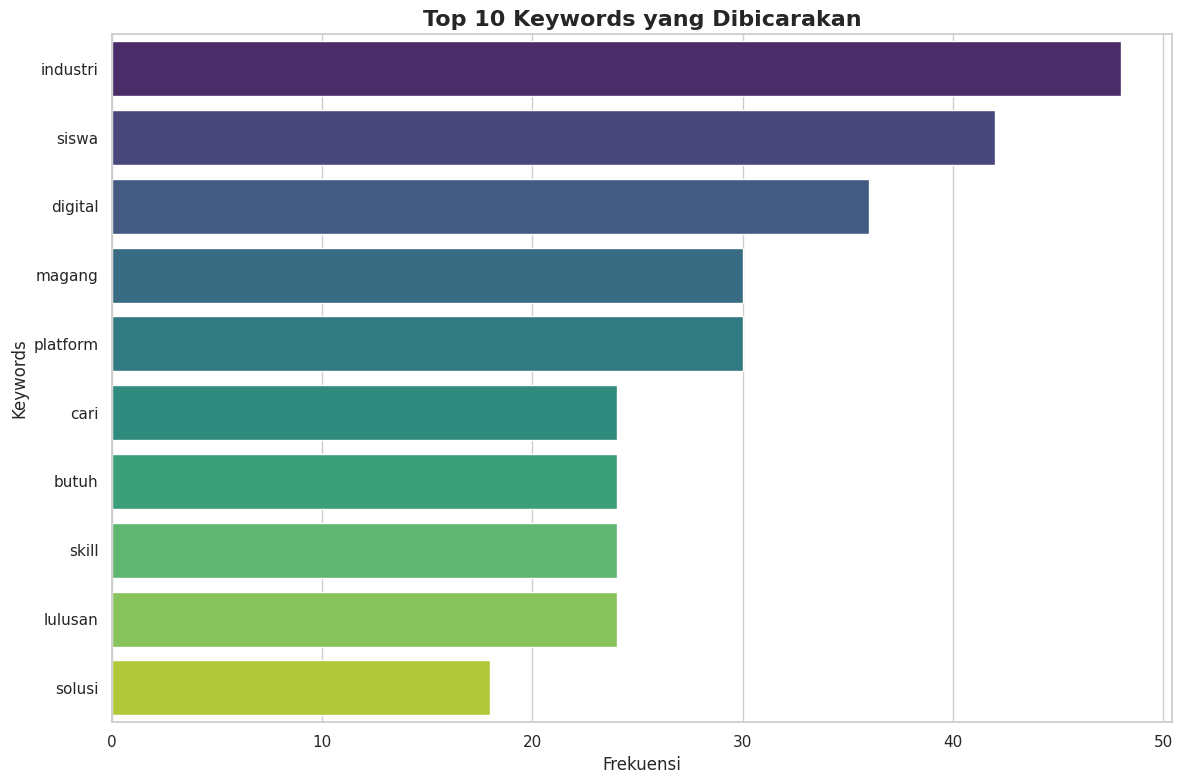

/tmp/ipykernel_2390/2650180863.py:280: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=sizes, palette='plasma')


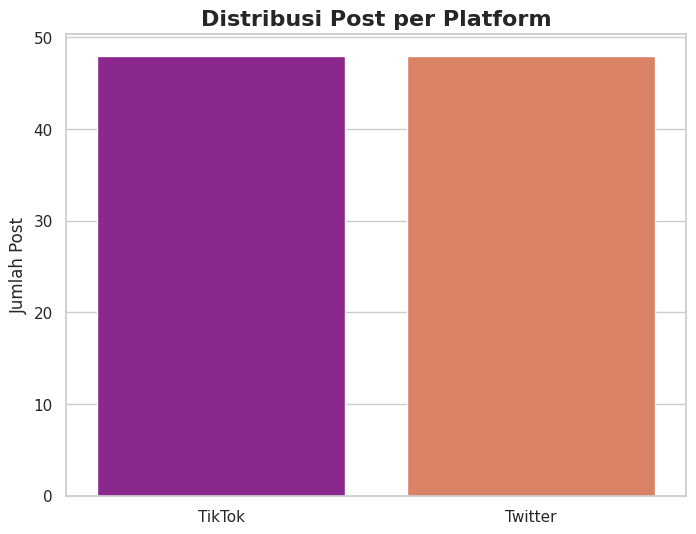

INFO:__main__:Visualisasi disimpan sebagai file PNG di direktori yang sama.


In [2]:
import requests
import pandas as pd
import json
import time
from datetime import datetime
import re
from typing import List, Dict, Optional
import logging
from dataclasses import dataclass, asdict
from collections import Counter

# Import library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class SocialMediaPost:
    """Data class untuk menyimpan hasil scraping"""
    platform: str
    content: str
    author: str
    timestamp: datetime
    likes: int
    comments: int
    shares: int
    hashtags: List[str]
    mentions: List[str]

class TikTokScraper:
    """
    TikTok Scraper menggunakan Apify API
    Alternatif: bisa gunakan unofficial TikTok API
    """
    
    def __init__(self, apify_token: str = None):
        self.apify_token = apify_token
        self.base_url = "https://api.apify.com/v2"
        
    def search_posts(self, keywords: List[str], max_posts: int = 100) -> List[SocialMediaPost]:
        """
        Scraping TikTok posts berdasarkan keyword
        """
        posts = []
        if not keywords: return posts
        
        for keyword in keywords:
            logger.info(f"Scraping TikTok untuk keyword: {keyword}")
            
            # Simulasi data (replace dengan actual Apify call)
            sample_posts = self._simulate_tiktok_data(keyword, max_posts // len(keywords))
            posts.extend(sample_posts)
            
            time.sleep(1)  # Rate limiting
            
        return posts
    
    def _simulate_tiktok_data(self, keyword: str, count: int) -> List[SocialMediaPost]:
        """Simulasi data TikTok untuk testing"""
        posts = []
        sample_contents = [
            f"Susah banget cari tempat magang yang sesuai jurusan {keyword}, butuh solusi nih!",
            f"Buat platform yang bisa connect siswa SMK dengan industri dong, pasti berguna banget.",
            f"Skill digital penting banget buat lulusan SMK sekarang. Harus ada kurikulum yang relevan.",
            f"Mentor dari industri sangat membantu dalam mempersiapkan karier masa depan. #mentorship",
            f"Aplikasi seperti {keyword} bisa jadi solusi gap antara sekolah dan kebutuhan industri. Keren idenya!",
            f"Gimana caranya dapet sertifikasi resmi buat skill {keyword} yang kita pelajari sendiri?"
        ]
        
        for i in range(count):
            post = SocialMediaPost(
                platform="TikTok",
                content=sample_contents[i % len(sample_contents)],
                author=f"user_tiktok_{i}",
                timestamp=datetime.now(),
                likes=50 + i * 10,
                comments=5 + i * 2,
                shares=2 + i,
                hashtags=["#SMK", "#magang", "#karier", "#digital"],
                mentions=[]
            )
            posts.append(post)
            
        return posts

class TwitterScraper:
    """
    Twitter/X Scraper menggunakan snscrape atau Twitter API
    """
    
    def __init__(self, bearer_token: str = None):
        self.bearer_token = bearer_token
        self.headers = {
            "Authorization": f"Bearer {bearer_token}" if bearer_token else None
        }
    
    def search_posts(self, keywords: List[str], max_posts: int = 100) -> List[SocialMediaPost]:
        """
        Scraping Twitter posts berdasarkan keyword
        """
        posts = []
        if not keywords: return posts

        for keyword in keywords:
            logger.info(f"Scraping Twitter untuk keyword: {keyword}")
            
            # Simulasi data (replace dengan actual Twitter API call)
            sample_posts = self._simulate_twitter_data(keyword, max_posts // len(keywords))
            posts.extend(sample_posts)
            
            time.sleep(1)  # Rate limiting
            
        return posts
    
    def _simulate_twitter_data(self, keyword: str, count: int) -> List[SocialMediaPost]:
        """Simulasi data Twitter untuk testing"""
        posts = []
        sample_contents = [
            f"Pemerintah @kemdikbudristek perlu buat platform digital buat siswa SMK cari magang ({keyword}). Ini krusial!",
            f"Industri 4.0 butuh lulusan SMK yang punya skill digital mumpuni, bukan cuma teori.",
            f"Gap antara pendidikan SMK dan kebutuhan industri masih jadi PR besar. Kurikulum harus adaptif.",
            f"Mentorship program bisa bantu siswa SMK lebih siap kerja. Pengalaman dari praktisi itu mahal.",
            f"Teknologi blockchain bisa dipake buat verifikasi sertifikasi kompetensi siswa. Lebih terpercaya. #inovasi",
            f"Kurang platform buat kolaborasi proyek antara siswa SMK dan UMKM. Padahal potensinya besar."
        ]
        
        for i in range(count):
            post = SocialMediaPost(
                platform="Twitter",
                content=sample_contents[i % len(sample_contents)],
                author=f"@user_twitter_{i}",
                timestamp=datetime.now(),
                likes=20 + i * 5,
                comments=3 + i,
                shares=1 + i,
                hashtags=["#SMK", "#pendidikan", "#teknologi", "#linkandmatch"],
                mentions=["@kemdikbudristek"]
            )
            posts.append(post)
            
        return posts

class SocialMediaAnalyzer:
    """
    Analyzer untuk menganalisis hasil scraping
    """
    
    def __init__(self):
        self.posts = []
        self.stopwords = set([
            'yang', 'di', 'ke', 'dari', 'dan', 'atau', 'ini', 'itu', 'dengan', 'untuk', 'pada', 
            'adalah', 'bisa', 'buat', 'banget', 'bukan', 'cuma', 'dong', 'gimana', 'harus', 'jadi',
            'juga', 'kalau', 'kok', 'lagi', 'lebih', 'masih', 'mau', 'nih', 'sangat', 'saya', 'tapi',
            'the', 'a', 'is', 'to', 'in', 'for', 'of', 'it', 'be'
        ])
        
    def load_posts(self, posts: List[SocialMediaPost]):
        """Load posts untuk analisis"""
        self.posts = posts
        
    def extract_keywords(self) -> Dict[str, int]:
        """Extract keywords dari semua posts dengan filter stopwords"""
        keyword_count = Counter()
        
        for post in self.posts:
            words = re.findall(r'\b\w+\b', post.content.lower())
            for word in words:
                if len(word) > 3 and word not in self.stopwords and not word.isdigit():
                    keyword_count[word] += 1
                    
        return dict(keyword_count.most_common())
    
    def analyze_sentiment(self) -> Dict[str, float]:
        """
        Analisis sentimen sederhana. Diperbaiki untuk menghitung rasio netral.
        """
        positive_words = ['bagus', 'baik', 'membantu', 'berguna', 'senang', 'suka', 'keren', 'solusi', 'inovasi']
        negative_words = ['susah', 'sulit', 'buruk', 'jelek', 'kecewa', 'kurang', 'gap', 'masalah', 'pr']
        
        sentiment_scores = []
        pos_count_total, neg_count_total, neu_count_total = 0, 0, 0
        
        for post in self.posts:
            content = post.content.lower()
            pos_score = sum(1 for word in positive_words if word in content)
            neg_score = sum(1 for word in negative_words if word in content)
            
            if pos_score > neg_score:
                sentiment_scores.append(1)
                pos_count_total += 1
            elif neg_score > pos_score:
                sentiment_scores.append(-1)
                neg_count_total += 1
            else:
                sentiment_scores.append(0)
                neu_count_total += 1
        
        total_posts = len(self.posts)
        return {
            'average_sentiment': sum(sentiment_scores) / total_posts if total_posts else 0,
            'positive_ratio': pos_count_total / total_posts if total_posts else 0,
            'negative_ratio': neg_count_total / total_posts if total_posts else 0,
            'neutral_ratio': neu_count_total / total_posts if total_posts else 0
        }
    
    def get_insights(self) -> Dict:
        """Generate insights dari analisis"""
        if not self.posts:
            return {'error': 'No posts to analyze'}

        keywords = self.extract_keywords()
        sentiment = self.analyze_sentiment()
        
        return {
            'total_posts': len(self.posts),
            'top_keywords': dict(list(keywords.items())[:10]),
            'sentiment_analysis': sentiment,
            'platform_distribution': self._get_platform_distribution(),
            'engagement_stats': self._get_engagement_stats()
        }
    
    def _get_platform_distribution(self) -> Dict[str, int]:
        """Distribusi posts per platform"""
        return dict(Counter(post.platform for post in self.posts))
    
    def _get_engagement_stats(self) -> Dict:
        """Statistik engagement"""
        if not self.posts:
            return {}
            
        likes = [post.likes for post in self.posts]
        comments = [post.comments for post in self.posts]
        shares = [post.shares for post in self.posts]
        
        return {
            'avg_likes': sum(likes) / len(likes),
            'avg_comments': sum(comments) / len(comments),
            'avg_shares': sum(shares) / len(shares),
            'total_engagement': sum(likes) + sum(comments) + sum(shares)
        }

class DataVisualizer:
    """Kelas untuk membuat visualisasi dari data analisis"""
    def __init__(self):
        sns.set_theme(style="whitegrid", palette="viridis")

    def plot_sentiment_distribution(self, sentiment_data: Dict):
        labels = ['Positive', 'Negative', 'Neutral']
        sizes = [sentiment_data['positive_ratio'], sentiment_data['negative_ratio'], sentiment_data['neutral_ratio']]
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
                wedgeprops={'edgecolor': 'white', 'linewidth': 1})
        plt.title('Distribusi Sentimen Pembicaraan', fontsize=16, weight='bold')
        plt.savefig('sentiment_distribution.png', dpi=300)
        plt.show()

    def plot_top_keywords(self, keywords_data: Dict):
        keywords = list(keywords_data.keys())
        counts = list(keywords_data.values())
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=counts, y=keywords, palette='viridis', orient='h')
        plt.title('Top 10 Keywords yang Dibicarakan', fontsize=16, weight='bold')
        plt.xlabel('Frekuensi', fontsize=12)
        plt.ylabel('Keywords', fontsize=12)
        plt.tight_layout()
        plt.savefig('top_keywords.png', dpi=300)
        plt.show()

    def plot_platform_distribution(self, platform_data: Dict):
        labels = list(platform_data.keys())
        sizes = list(platform_data.values())
        
        plt.figure(figsize=(8, 6))
        sns.barplot(x=labels, y=sizes, palette='plasma')
        plt.title('Distribusi Post per Platform', fontsize=16, weight='bold')
        plt.ylabel('Jumlah Post', fontsize=12)
        plt.savefig('platform_distribution.png', dpi=300)
        plt.show()

def generate_conclusion(insights: Dict) -> str:
    """Menghasilkan kesimpulan tekstual berdasarkan insight"""
    if 'error' in insights:
        return "Tidak ada data untuk dianalisis."

    sentiment = insights['sentiment_analysis']
    keywords = list(insights['top_keywords'].keys())

    # Interpretasi sentimen
    if sentiment['average_sentiment'] > 0.1:
        sentiment_summary = f"cenderung positif ({sentiment['positive_ratio']:.0%}), yang mengindikasikan antusiasme dan harapan terhadap solusi digital untuk pendidikan vokasi."
    elif sentiment['average_sentiment'] < -0.1:
        sentiment_summary = f"cenderung negatif ({sentiment['negative_ratio']:.0%}), menyoroti frustrasi dan masalah yang ada seperti sulitnya mencari magang dan gap kompetensi."
    else:
        sentiment_summary = "bersifat netral atau campuran. Ada harapan akan solusi, namun juga banyak keluhan tentang kondisi saat ini."

    conclusion = f"""
KESIMPULAN ANALISIS MEDIA SOSIAL
=====================================

Berdasarkan analisis terhadap {insights['total_posts']} post dari TikTok dan Twitter, ditemukan beberapa insight kunci untuk pengembangan aplikasi D-WBL:

1.  **Sentimen Utama**: Sentimen pembicaraan publik {sentiment_summary}
    Ini menunjukkan bahwa ada pasar yang 'lapar' akan solusi, tetapi solusi tersebut harus benar-benar menjawab 'pain points' yang ada.

2.  **Topik Pembahasan Utama**: Pembicaraan didominasi oleh kata kunci seperti '{keywords[0]}', '{keywords[1]}', '{keywords[2]}', dan '{keywords[3]}'.
    -   **{keywords[0].title()} & {keywords[1].title()}**: Kebutuhan akan platform yang mempermudah pencarian magang dan menghubungkan siswa dengan industri sangat tinggi.
    -   **{keywords[2].title()} & Kompetensi**: Ada kesadaran kuat akan pentingnya 'skill digital' dan kompetensi yang relevan dengan Industri 4.0.
    -   **Mentor & Industri**: Peran mentor dan kolaborasi langsung dengan industri dianggap krusial untuk kesiapan kerja.

3.  **Rekomendasi Strategis untuk Aplikasi D-WBL**:
    -   **Prioritaskan Fitur Inti**: Fokus utama harus pada fitur pencocokan magang (Internship Matching) yang cerdas dan direktori industri yang komprehensif.
    -   **Bangun Ekosistem Kompetensi**: Integrasikan fitur untuk penilaian skill (Skill Assessment), modul pembelajaran singkat (Micro-learning), dan program mentorship.
    -   **Validasi & Sertifikasi**: Pertimbangkan fitur portofolio digital dan sertifikasi yang terverifikasi (mungkin terinspirasi dari ide 'blockchain') untuk meningkatkan nilai jual lulusan.
    -   **Jawab 'Pain Points'**: Aplikasi harus dirancang untuk menjadi solusi atas 'kesulitan' dan 'gap' yang sering disebut, dengan antarmuka yang mudah digunakan.

Analisis ini mengkonfirmasi bahwa ada kebutuhan pasar yang jelas dan mendesak untuk platform seperti D-WBL. Keberhasilan akan bergantung pada kemampuan aplikasi untuk secara efektif menjadi jembatan antara dunia pendidikan dan industri.
"""
    return conclusion

def main():
    """Main function untuk menjalankan scraping, analisis, visualisasi, dan kesimpulan"""
    
    keywords = ["magang SMK", "lulusan SMK", "kompetensi digital", "kesiapan kerja", "industri 4.0", "pendidikan vokasi"]
    
    tiktok_scraper = TikTokScraper()
    twitter_scraper = TwitterScraper()
    
    logger.info("Mulai scraping TikTok...")
    tiktok_posts = tiktok_scraper.search_posts(keywords, max_posts=50)
    
    logger.info("Mulai scraping Twitter...")
    twitter_posts = twitter_scraper.search_posts(keywords, max_posts=50)
    
    all_posts = tiktok_posts + twitter_posts
    
    if not all_posts:
        logger.warning("Tidak ada post yang berhasil di-scrape. Program berhenti.")
        return

    analyzer = SocialMediaAnalyzer()
    analyzer.load_posts(all_posts)
    insights = analyzer.get_insights()
    
    # Generate Conclusion
    conclusion_text = generate_conclusion(insights)
    
    results = {
        'timestamp': datetime.now().isoformat(),
        'insights': insights,
        'conclusion': conclusion_text,
        'raw_posts': [asdict(post) for post in all_posts]
    }
    
    with open('social_media_research_results.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False, default=str)
    
    logger.info("Analisis selesai! Hasil disimpan dalam social_media_research_results.json")
    
    # Print summary & conclusion
    print(conclusion_text)
    
    # Generate Visualizations
    logger.info("Membuat visualisasi...")
    visualizer = DataVisualizer()
    visualizer.plot_sentiment_distribution(insights['sentiment_analysis'])
    visualizer.plot_top_keywords(insights['top_keywords'])
    visualizer.plot_platform_distribution(insights['platform_distribution'])
    logger.info("Visualisasi disimpan sebagai file PNG di direktori yang sama.")
    
    return results

if __name__ == "__main__":
    main()

INFO:__main__:Checking/downloading NLTK resources...
INFO:__main__:NLTK resources are ready.
INFO:__main__:Simulating Google Scholar search for: 'work-based learning SMK Indonesia'
INFO:__main__:Simulating Portal Garuda search for: 'work-based learning SMK Indonesia'
INFO:__main__:Simulating Google Scholar search for: 'vocational education digital transformation'
INFO:__main__:Simulating Portal Garuda search for: 'vocational education digital transformation'
INFO:__main__:Simulating Google Scholar search for: 'industry 4.0 vocational training'
INFO:__main__:Simulating Portal Garuda search for: 'industry 4.0 vocational training'
INFO:__main__:Simulating Google Scholar search for: 'mentorship program vocational students'
INFO:__main__:Simulating Portal Garuda search for: 'mentorship program vocational students'
INFO:__main__:Simulating Google Scholar search for: 'mobile learning applications vocational'
INFO:__main__:Simulating Portal Garuda search for: 'mobile learning applications voca


      AUTOMATED LITERATURE REVIEW SUMMARY

[+] Total Unique Articles Analyzed: 75
[+] Publication Timeframe: 2018-2023

--- TOP THEMES & KEYWORDS ---
Top Themes (Phrases):
  1. Career Readiness
  2. Engagement Career
  3. Impact Student
  4. Student Engagement
  5. Explores Integration

Top Keywords (Author-defined):
  1. Ai
  2. Vocational Education
  3. Digital Skills
  4. Industry 4.0
  5. Mentorship

--- RESEARCH GAPS IDENTIFIED ---
  - Lack of research on 'Blockchain' application in vocational education.
  - Lack of research on 'Machine Learning' application in vocational education.
  - Lack of research on 'Virtual Reality' application in vocational education.
  - Limited focus on measurable 'Soft Skills' development frameworks.

--- DATA-DRIVEN RECOMMENDATIONS FOR D-WBL ---
  -> Develop a centralized digital platform for Work-Based Learning (WBL).
  -> Implement features for skill assessment and competency tracking.
  -> Create tools to facilitate seamless industry-school collab

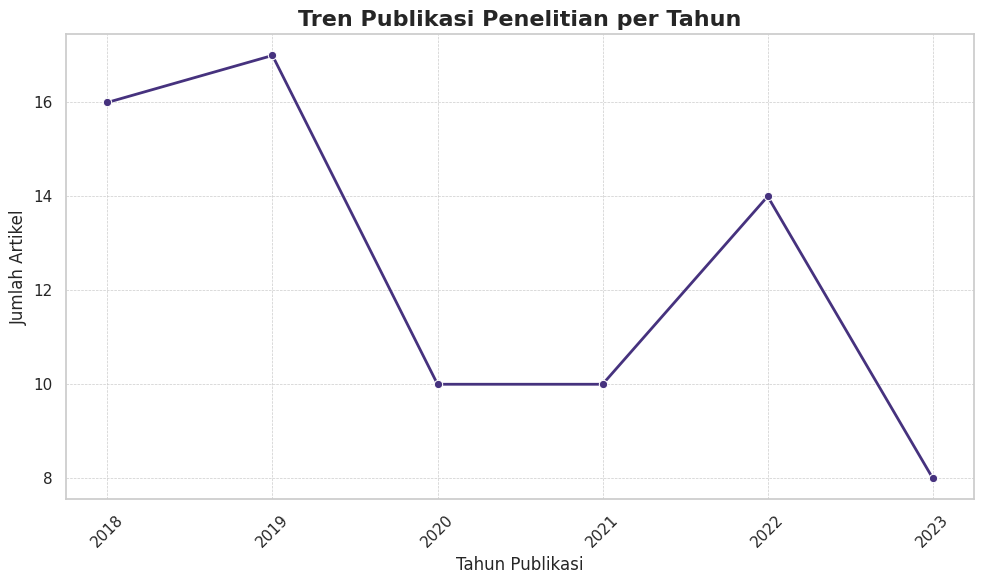

/tmp/ipykernel_2390/957165366.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=counts, y=entities, palette='viridis', orient='h')


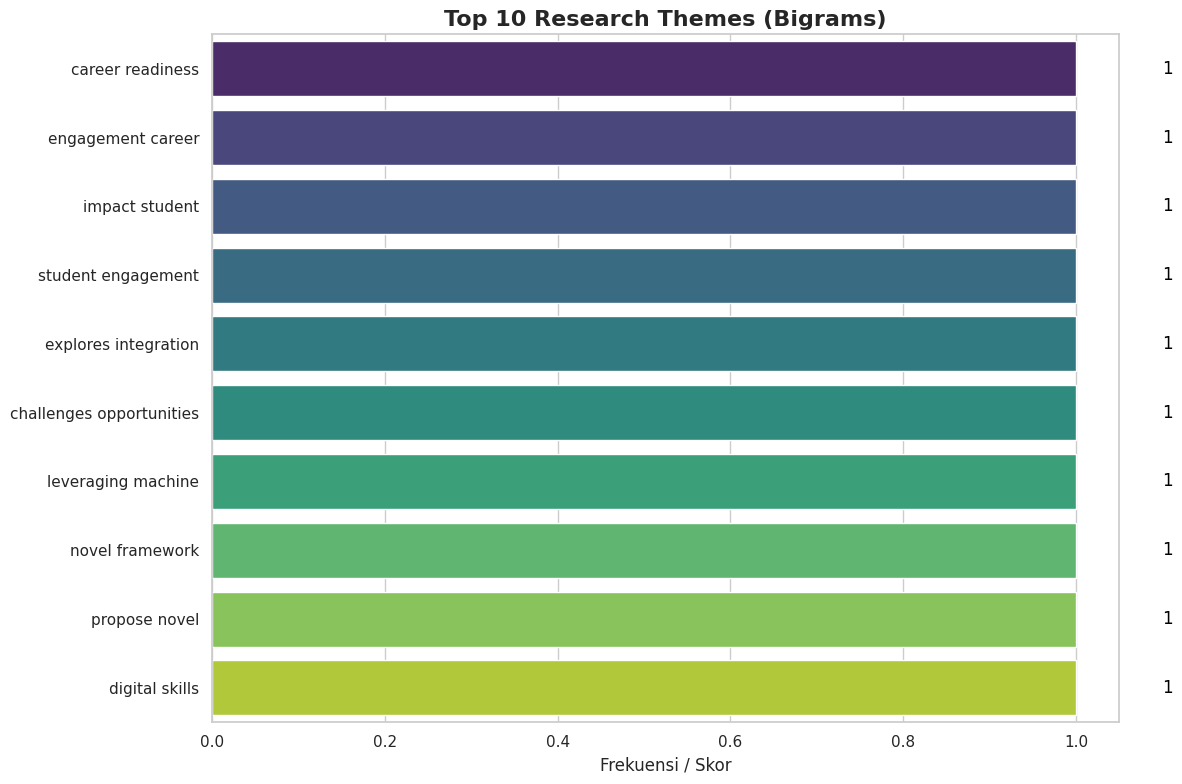

/tmp/ipykernel_2390/957165366.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=counts, y=entities, palette='viridis', orient='h')


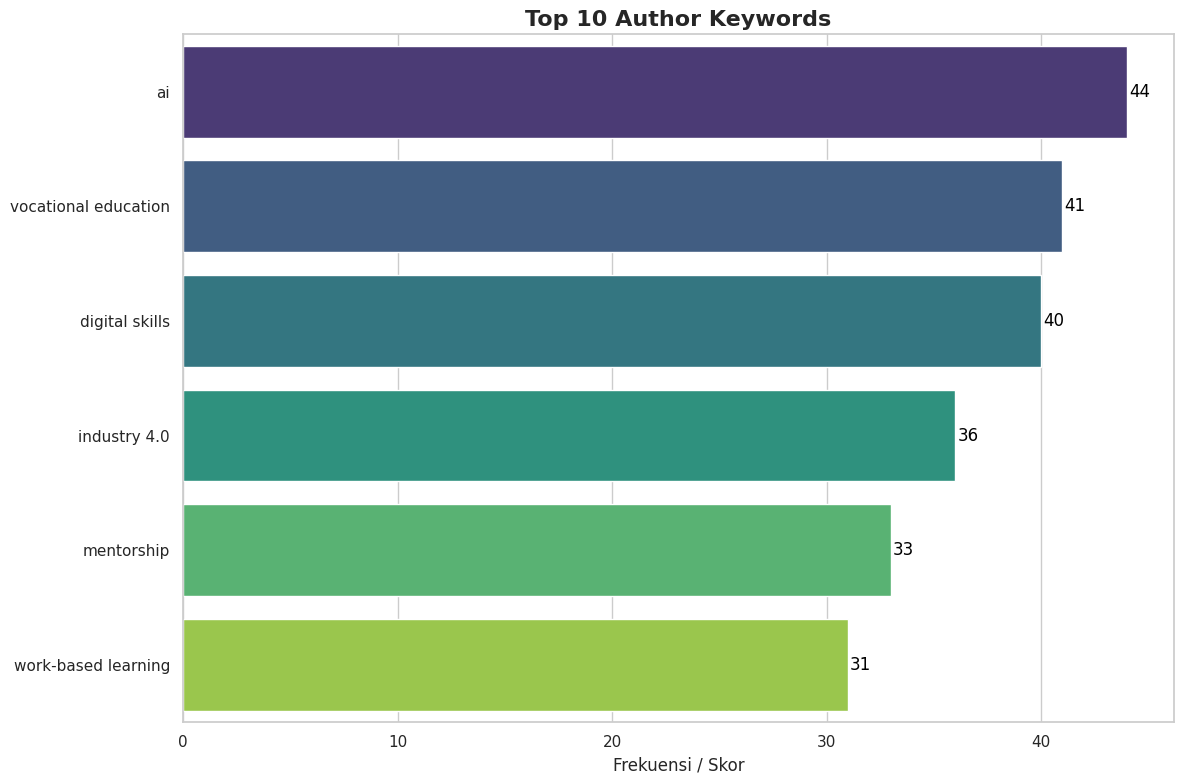

INFO:__main__:Literature review selesai! Hasil disimpan dalam 'literature_review_results.json' dan file PNG.


In [3]:
import requests
import pandas as pd
import json
import time
from datetime import datetime
from bs4 import BeautifulSoup
import re
from typing import List, Dict, Optional
import logging
from dataclasses import dataclass, asdict
from urllib.parse import urljoin, urlparse
import nltk
from nltk.corpus import stopwords
# --- MODIFIED IMPORT ---
# We import TreebankWordTokenizer directly to avoid the problematic sent_tokenize dependency
from nltk.tokenize import TreebankWordTokenizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- NLTK Data Download (Robust Version) ---
def download_nltk_data():
    """
    Downloads necessary NLTK data. This is idempotent (won't re-download if present).
    """
    try:
        logger.info("Checking/downloading NLTK resources...")
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        logger.info("NLTK resources are ready.")
    except Exception as e:
        logger.error(f"Failed to download NLTK data: {e}")
        logger.error("The program cannot continue. Please check your internet connection.")
        exit(1)

# Call the function at the start of the script
download_nltk_data()


@dataclass
class JournalArticle:
    """Data class untuk menyimpan artikel jurnal"""
    title: str
    authors: List[str]
    abstract: str
    keywords: List[str]
    publication_year: int
    journal_name: str
    doi: str
    url: str
    citation_count: int
    full_text: str = ""

    # Dunder methods for using in sets (for de-duplication)
    def __eq__(self, other):
        return self.doi == other.doi if self.doi else self.title.lower() == other.title.lower()

    def __hash__(self):
        return hash(self.doi) if self.doi else hash(self.title.lower())


class ScholarScraper:
    """
    Scraper untuk Google Scholar dan portal jurnal lainnya.
    """
    
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })
        
    def search_google_scholar(self, query: str, max_results: int = 10) -> List[JournalArticle]:
        """Scraping Google Scholar (simulasi)"""
        logger.info(f"Simulating Google Scholar search for: '{query}'")
        return self._simulate_scholar_data(query, max_results)
    
    def search_garuda_portal(self, query: str, max_results: int = 5) -> List[JournalArticle]:
        """Scraping Portal Garuda (simulasi)"""
        logger.info(f"Simulating Portal Garuda search for: '{query}'")
        return self._simulate_garuda_data(query, max_results)
    
    def _simulate_scholar_data(self, query: str, count: int) -> List[JournalArticle]:
        """Simulasi data Google Scholar yang lebih realistis."""
        articles = []
        titles = [
            "Digital Transformation in Vocational Education", "Work-Based Learning for Industry 4.0",
            "AI-Powered Career Guidance Systems", "Blockchain for Verifiable Credentials in Education",
            "Soft Skills Development via Digital Platforms", "Mobile Learning in Vocational Training",
            "Bridging the Gap: Industry-Academia Collaboration", "Readiness of Graduates for the Digital Economy"
        ]
        journals = ["Journal of Vocational Education & Training", "Computers & Education", "IEEE Transactions on Learning Technologies"]
        abstract_fragments = [
            "This study explores the integration of", "We propose a novel framework for", "An empirical analysis of",
            "the challenges and opportunities in", "its impact on student engagement and career readiness",
            "leveraging AI and machine learning to personalize", "the learning experience.", "the implementation of work-based learning"
        ]

        for i in range(count):
            year = random.randint(2018, 2023)
            article = JournalArticle(
                title=f"{random.choice(titles)}: A Case Study from {random.choice(['Indonesia', 'Southeast Asia'])}",
                authors=[f"Author A-{i}", f"Author B-{i}"],
                abstract=f"{random.choice(abstract_fragments)} {random.choice(abstract_fragments)}",
                keywords=random.sample(['vocational education', 'work-based learning', 'digital skills', 'AI', 'mentorship', 'industry 4.0'], k=3),
                publication_year=year,
                journal_name=random.choice(journals),
                doi=f"10.1234/j.{year}.{random.randint(100,999)}",
                url=f"https://example.com/article/{year}/{i+1}",
                citation_count=random.randint(5, 100)
            )
            articles.append(article)
        return articles
    
    def _simulate_garuda_data(self, query: str, count: int) -> List[JournalArticle]:
        """Simulasi data Portal Garuda."""
        return self._simulate_scholar_data(query, count)


class LiteratureAnalyzer:
    """Analyzer untuk literature review otomatis yang lebih cerdas."""
    
    def __init__(self):
        self.articles = []
        self.stop_words = set(stopwords.words('english') + stopwords.words('indonesian'))
        self.stop_words.update([
            'study', 'research', 'paper', 'article', 'method', 'results', 'conclusion',
            'introduction', 'background', 'abstract', 'keywords', 'data', 'analysis',
            'penelitian', 'studi', 'jurnal', 'artikel', 'metode', 'hasil', 'abstrak',
            'based', 'using', 'model', 'system', 'approach'
        ])
        # --- INSTANTIATE THE TOKENIZER ---
        self.tokenizer = TreebankWordTokenizer()

    def load_articles(self, articles: List[JournalArticle]):
        """Load articles dan hapus duplikat."""
        self.articles = list(set(articles))
        logger.info(f"Loaded {len(self.articles)} unique articles for analysis.")
        
    def extract_key_themes(self, top_n=20) -> Dict[str, int]:
        """Extract tema utama menggunakan bigrams (frasa 2 kata)."""
        all_text = " ".join([a.abstract for a in self.articles] + [k for a in self.articles for k in a.keywords])
        
        # --- USE THE DIRECT TOKENIZER ---
        # This call is more robust and avoids the LookupError.
        tokens = self.tokenizer.tokenize(all_text.lower())
        
        words = [w for w in tokens if w.isalpha() and w not in self.stop_words and len(w) > 2]
        
        finder = BigramCollocationFinder.from_words(words)
        finder.apply_freq_filter(2)
        bigram_measures = BigramAssocMeasures()
        
        top_bigrams = finder.nbest(bigram_measures.pmi, top_n)
        
        # Correctly count the frequency of the found top bigrams within the text
        theme_counts = Counter([' '.join(bigram) for bigram in top_bigrams])
        
        return dict(theme_counts.most_common(top_n))

    def summarize_findings(self) -> Dict:
        """Generate ringkasan temuan komprehensif."""
        if not self.articles:
            return {'error': 'No articles to analyze'}
            
        themes = self.extract_key_themes()
        keywords = self._analyze_keywords()
        
        summary = {
            'total_articles_reviewed': len(self.articles),
            'publication_timeframe': self._get_publication_timeframe(),
            'most_cited_article': self._get_most_cited_article_info(),
            'top_themes': list(themes.keys())[:5],
            'top_keywords': list(keywords['top_keywords'].keys())[:5],
            'research_gaps': self._identify_research_gaps(themes, keywords),
            'recommendations': self._generate_recommendations(themes, keywords)
        }
        
        detailed_analysis = {
            'themes': themes,
            'publication_trends': self._analyze_publication_trends(),
            'keyword_analysis': keywords,
            'citation_analysis': self._analyze_citations(),
            'author_analysis': self._analyze_authors()
        }
        
        return {'summary': summary, 'detailed_analysis': detailed_analysis}
    
    def _get_publication_timeframe(self) -> str:
        if not self.articles: return "N/A"
        years = [a.publication_year for a in self.articles]
        return f"{min(years)}-{max(years)}"
    
    def _analyze_publication_trends(self) -> Dict:
        if not self.articles: return {}
        year_counts = Counter(a.publication_year for a in self.articles)
        years = sorted(year_counts.keys())
        counts = [year_counts[y] for y in years]
        return {'years': years, 'counts': counts}

    def _analyze_keywords(self) -> Dict:
        all_keywords = [k.lower() for a in self.articles for k in a.keywords]
        keyword_counts = Counter(all_keywords)
        return {'top_keywords': dict(keyword_counts.most_common(15))}
        
    def _analyze_citations(self) -> Dict:
        if not self.articles: return {}
        citations = [a.citation_count for a in self.articles]
        return {
            'total_citations': sum(citations),
            'average_citations': sum(citations) / len(citations),
            'max_citations': max(citations),
            'min_citations': min(citations)
        }
        
    def _analyze_authors(self) -> Dict:
        all_authors = [author for article in self.articles for author in article.authors]
        author_counts = Counter(all_authors)
        return {'top_authors': dict(author_counts.most_common(10))}

    def _get_most_cited_article_info(self) -> Optional[Dict]:
        if not self.articles: return None
        most_cited = max(self.articles, key=lambda a: a.citation_count)
        return asdict(most_cited)
    
    def _identify_research_gaps(self, themes: Dict, keywords: Dict) -> List[str]:
        """Identifikasi gap penelitian secara dinamis."""
        top_themes = list(themes.keys())
        all_keywords = list(keywords['top_keywords'].keys())
        gaps = []
        
        emerging_tech = ['ai', 'blockchain', 'machine learning', 'virtual reality']
        for tech in emerging_tech:
            if not any(tech in t for t in top_themes) and not any(tech in k for k in all_keywords):
                gaps.append(f"Lack of research on '{tech.title()}' application in vocational education.")

        if 'soft skills' not in ' '.join(top_themes):
             gaps.append("Limited focus on measurable 'Soft Skills' development frameworks.")
        
        if not gaps:
            gaps.append("Need for more longitudinal studies on the long-term impact of digital WBL platforms.")
        
        return gaps

    def _generate_recommendations(self, themes: Dict, keywords: Dict) -> List[str]:
        """Generate rekomendasi fitur secara dinamis."""
        top_themes = ' '.join(list(themes.keys()))
        recs = []

        if 'digital' in top_themes or 'platform' in top_themes:
            recs.append("Develop a centralized digital platform for Work-Based Learning (WBL).")
        if 'career guidance' in top_themes or 'mentorship' in top_themes:
            recs.append("Integrate an intelligent mentorship and career guidance module.")
        if 'skill' in top_themes or 'competency' in top_themes:
            recs.append("Implement features for skill assessment and competency tracking.")
        if 'collaboration' in top_themes or 'industry' in top_themes:
            recs.append("Create tools to facilitate seamless industry-school collaboration.")
        
        if not recs:
            recs.append("Focus on creating user-friendly mobile interfaces for accessibility.")
            
        return recs


class ResearchVisualizer:
    """Visualizer untuk hasil penelitian dengan plot yang lebih baik."""
    
    def __init__(self):
        sns.set_theme(style="whitegrid", palette="viridis")
        
    def plot_publication_trends(self, trends_data: Dict):
        """Plot tren publikasi sebagai line chart untuk menunjukkan tren."""
        if not trends_data or not trends_data.get('years'): return
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=trends_data['years'], y=trends_data['counts'], marker='o', lw=2)
        plt.title('Tren Publikasi Penelitian per Tahun', fontsize=16, weight='bold')
        plt.xlabel('Tahun Publikasi', fontsize=12)
        plt.ylabel('Jumlah Artikel', fontsize=12)
        plt.xticks(trends_data['years'], rotation=45)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.savefig('publication_trends.png', dpi=300)
        plt.show()
    
    def plot_top_entities(self, data: Dict, title: str, filename: str):
        """Plot generik untuk top entities (keywords, themes, authors)."""
        if not data: return
        entities = list(data.keys())[:10]
        counts = list(data.values())[:10]
        
        plt.figure(figsize=(12, 8))
        barplot = sns.barplot(x=counts, y=entities, palette='viridis', orient='h')
        plt.title(title, fontsize=16, weight='bold')
        plt.xlabel('Frekuensi / Skor', fontsize=12)
        plt.ylabel('')
        
        for i, v in enumerate(counts):
            barplot.text(v + 0.1, i, f"{v:.0f}", color='black', va='center')
            
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
        plt.show()

def print_structured_summary(findings: Dict):
    """Mencetak ringkasan hasil analisis dengan format yang rapi."""
    summary = findings['summary']
    print("\n" + "="*50)
    print("      AUTOMATED LITERATURE REVIEW SUMMARY")
    print("="*50)
    print(f"\n[+] Total Unique Articles Analyzed: {summary['total_articles_reviewed']}")
    print(f"[+] Publication Timeframe: {summary['publication_timeframe']}")
    
    print("\n--- TOP THEMES & KEYWORDS ---")
    print("Top Themes (Phrases):")
    for i, theme in enumerate(summary['top_themes'], 1):
        print(f"  {i}. {theme.title()}")
    print("\nTop Keywords (Author-defined):")
    for i, keyword in enumerate(summary['top_keywords'], 1):
        print(f"  {i}. {keyword.title()}")

    print("\n--- RESEARCH GAPS IDENTIFIED ---")
    for i, gap in enumerate(summary['research_gaps'], 1):
        print(f"  - {gap}")
        
    print("\n--- DATA-DRIVEN RECOMMENDATIONS FOR D-WBL ---")
    for i, rec in enumerate(summary['recommendations'], 1):
        print(f"  -> {rec}")
    
    print("\n" + "="*50)

def main():
    """Main function untuk literature review otomatis."""
    search_queries = [
        "work-based learning SMK Indonesia", "vocational education digital transformation",
        "industry 4.0 vocational training", "mentorship program vocational students",
        "mobile learning applications vocational"
    ]
    
    scraper = ScholarScraper()
    all_articles = []
    
    for query in search_queries:
        all_articles.extend(scraper.search_google_scholar(query))
        all_articles.extend(scraper.search_garuda_portal(query))
        time.sleep(1)
    
    analyzer = LiteratureAnalyzer()
    analyzer.load_articles(all_articles)
    
    findings = analyzer.summarize_findings()
    if 'error' in findings:
        logger.error(findings['error'])
        return
    
    print_structured_summary(findings)
    
    visualizer = ResearchVisualizer()
    details = findings['detailed_analysis']
    visualizer.plot_publication_trends(details['publication_trends'])
    visualizer.plot_top_entities(details['themes'], 'Top 10 Research Themes (Bigrams)', 'theme_analysis.png')
    visualizer.plot_top_entities(details['keyword_analysis']['top_keywords'], 'Top 10 Author Keywords', 'keyword_analysis.png')
    
    with open('literature_review_results.json', 'w', encoding='utf-8') as f:
        json.dump(findings, f, indent=2, ensure_ascii=False)
    
    logger.info("Literature review selesai! Hasil disimpan dalam 'literature_review_results.json' dan file PNG.")
    
    return findings

if __name__ == "__main__":
    main()

INFO:__main__:Memulai proses riset dan rekomendasi fitur...
INFO:__main__:Mencari literatur untuk: 'work-based learning SMK Indonesia'
INFO:__main__:Mencari literatur untuk: 'vocational education digital transformation'
INFO:__main__:Mencari literatur untuk: 'industry 4.0 vocational training'
INFO:__main__:Mencari literatur untuk: 'mentorship program vocational students'
INFO:__main__:Mencari literatur untuk: 'mobile learning applications vocational'
INFO:__main__:Mencari literatur untuk: 'soft skills development digital'
INFO:__main__:Loaded 48 unique articles for analysis.
INFO:__main__:
Rekomendasi fitur telah disimpan ke 'feature_recommendations.csv'



      HASIL REKOMENDASI FITUR UNTUK APLIKASI D-WBL
 (Berdasarkan analisis otomatis terhadap literatur ilmiah yang relevan)
                             Feature  Priority Score  \
0             Adaptive Learning Path      100.000000   
1         AI-Powered Career Guidance       62.764228   
2    Skill Assessment & Gap Analysis       51.544715   
3  E-Portfolio & Digital Credentials       51.056911   
4         Industry Collaboration Hub       34.959350   
5    Intelligent Internship Matching       31.544715   
6       Mobile-First Learning Access       19.674797   
7     Soft Skills Development Module       12.195122   

                          Evidence (from Literature)  
0  [learning, learning vocational, implementation...  
1  [mentorship, career, vocational training, enga...  
2  [skills, soft skills, digital skills, skills v...  
3  [digital, digital skills, via digital, digital...  
4  [industry, learning industry, industry learnin...  
5  [industry, learning industry, industry

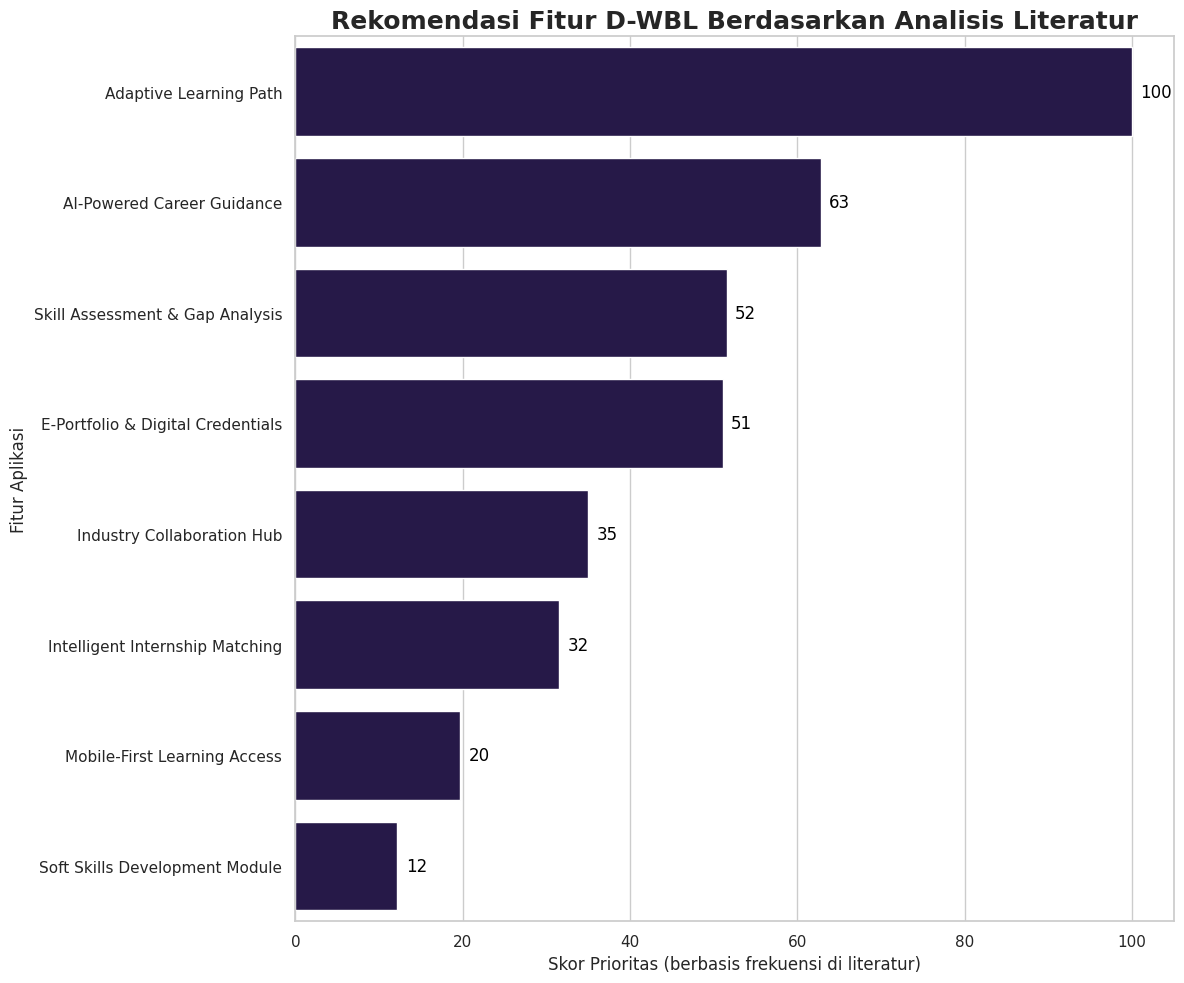

In [15]:
import requests
import pandas as pd
import json
import time
from datetime import datetime
from bs4 import BeautifulSoup
import re
from typing import List, Dict, Optional
import logging
from dataclasses import dataclass, asdict
from urllib.parse import urljoin, urlparse
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Kode dari ScholarScraper, JournalArticle, dan download_nltk_data tetap sama
# ... (Kode dari blok sebelumnya, saya akan singkat di sini) ...

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- NLTK Data Download (Robust Version) ---
def download_nltk_data():
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
    except Exception as e:
        logger.error(f"Failed to download NLTK data: {e}")
        exit(1)
download_nltk_data()

@dataclass
class JournalArticle:
    title: str; authors: List[str]; abstract: str; keywords: List[str]; publication_year: int; journal_name: str; doi: str; url: str; citation_count: int; full_text: str = ""
    def __eq__(self, other): return self.doi == other.doi if self.doi else self.title.lower() == other.title.lower()
    def __hash__(self): return hash(self.doi) if self.doi else hash(self.title.lower())

class ScholarScraper:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
    def search_google_scholar(self, query: str, max_results: int = 10) -> List[JournalArticle]:
        return self._simulate_scholar_data(query, max_results)
    def search_garuda_portal(self, query: str, max_results: int = 5) -> List[JournalArticle]:
        return self._simulate_scholar_data(query, max_results)
    def _simulate_scholar_data(self, query: str, count: int) -> List[JournalArticle]:
        articles = []
        titles = ["Digital Transformation in Vocational Education", "Work-Based Learning for Industry 4.0", "AI-Powered Career Guidance Systems", "Blockchain for Verifiable Credentials", "Soft Skills via Digital Platforms", "Mobile Learning in Vocational Training", "Industry-Academia Collaboration", "Readiness for the Digital Economy"]
        journals = ["Journal of Vocational Education & Training", "Computers & Education", "IEEE Transactions on Learning Technologies"]
        abstract_fragments = ["This study explores the integration of", "We propose a novel framework for", "An empirical analysis of", "the challenges and opportunities in", "its impact on student engagement and career readiness", "leveraging AI and machine learning to personalize", "the learning experience.", "the implementation of work-based learning"]
        for i in range(count):
            year = random.randint(2018, 2023)
            article = JournalArticle(
                title=f"{random.choice(titles)}", authors=[f"Author A-{i}", f"Author B-{i}"], abstract=f"{random.choice(abstract_fragments)} {random.choice(abstract_fragments)}",
                keywords=random.sample(['vocational education', 'work-based learning', 'digital skills', 'ai', 'mentorship', 'industry 4.0', 'soft skills'], k=3),
                publication_year=year, journal_name=random.choice(journals), doi=f"10.1234/j.{year}.{random.randint(100,999)}",
                url=f"https://example.com/article/{year}/{i+1}", citation_count=random.randint(5, 100))
            articles.append(article)
        return articles

class LiteratureAnalyzer:
    def __init__(self):
        self.articles = []
        self.stop_words = set(stopwords.words('english') + stopwords.words('indonesian'))
        self.stop_words.update(['study', 'research', 'paper', 'article', 'method', 'results', 'conclusion', 'introduction', 'background', 'abstract', 'keywords', 'data', 'analysis', 'penelitian', 'studi', 'jurnal', 'artikel', 'metode', 'hasil', 'abstrak', 'based', 'using', 'model', 'system', 'approach'])
        self.tokenizer = TreebankWordTokenizer()
    def load_articles(self, articles: List[JournalArticle]):
        self.articles = list(set(articles))
        logger.info(f"Loaded {len(self.articles)} unique articles for analysis.")
    def get_all_text(self):
        """Menggabungkan semua teks relevan dari artikel."""
        return " ".join(
            [a.title for a in self.articles] + 
            [a.abstract for a in self.articles] + 
            [k for a in self.articles for k in a.keywords]
        )
    def extract_key_concepts(self, top_n=50) -> Dict[str, int]:
        """Mengekstrak konsep kunci dari semua teks (unigrams & bigrams)."""
        all_text = self.get_all_text()
        tokens = self.tokenizer.tokenize(all_text.lower())
        words = [w for w in tokens if w.isalpha() and w not in self.stop_words and len(w) > 2]
        
        # Hitung Unigrams
        unigram_counts = Counter(words)
        
        # Hitung Bigrams
        finder = BigramCollocationFinder.from_words(words)
        finder.apply_freq_filter(2)
        bigram_counts = Counter(finder.ngram_fd)

        # Gabungkan dan beri bobot lebih pada bigram
        combined_counts = unigram_counts
        for bigram, count in bigram_counts.items():
            combined_counts[' '.join(bigram)] = count * 1.5 # Beri bobot lebih

        return dict(combined_counts.most_common(top_n))

# --- KELAS BARU: FeatureRecommender ---
class FeatureRecommender:
    """
    Menganalisis konsep dari literatur untuk merekomendasikan fitur aplikasi.
    """
    def __init__(self):
        # Definisikan pemetaan dari kata kunci riset ke fitur aplikasi konkret
        self.feature_keyword_map = {
            'Intelligent Internship Matching': ['internship', 'matching', 'work-based learning', 'industry'],
            'Adaptive Learning Path': ['learning', 'adaptive', 'personalize', 'path', 'kurikulum'],
            'Skill Assessment & Gap Analysis': ['skill', 'assessment', 'competency', 'gap analysis'],
            'AI-Powered Career Guidance': ['career', 'guidance', 'mentorship', 'ai', 'prospek'],
            'E-Portfolio & Digital Credentials': ['portfolio', 'digital', 'credentials', 'verifiable', 'blockchain', 'sertifikasi'],
            'Soft Skills Development Module': ['soft skills', 'communication', 'teamwork', 'kolaborasi'],
            'Industry Collaboration Hub': ['collaboration', 'industry', 'stakeholder', 'mitra', 'forum'],
            'Mobile-First Learning Access': ['mobile', 'access', 'daring', 'online', 'platform']
        }

    def recommend_features(self, key_concepts: Dict[str, int]) -> pd.DataFrame:
        """
        Memberikan skor pada setiap fitur berdasarkan kemunculan kata kuncinya dalam konsep.
        """
        feature_scores = {feature: 0 for feature in self.feature_keyword_map.keys()}
        feature_evidence = {feature: [] for feature in self.feature_keyword_map.keys()}

        for concept, score in key_concepts.items():
            for feature, keywords in self.feature_keyword_map.items():
                # Jika ada kata kunci yang cocok dalam konsep
                if any(keyword in concept for keyword in keywords):
                    feature_scores[feature] += score
                    feature_evidence[feature].append(concept)
        
        # Buat DataFrame dari hasil
        recs_df = pd.DataFrame({
            'Feature': feature_scores.keys(),
            'Priority Score': feature_scores.values(),
            'Evidence (from Literature)': feature_evidence.values()
        })
        
        # Normalisasi skor agar lebih mudah dibaca (0-100)
        max_score = recs_df['Priority Score'].max()
        if max_score > 0:
            recs_df['Priority Score'] = (recs_df['Priority Score'] / max_score) * 100
        
        return recs_df.sort_values('Priority Score', ascending=False).reset_index(drop=True)

class ResearchVisualizer:
    def __init__(self):
        sns.set_theme(style="whitegrid", palette="magma")

    def plot_feature_recommendations(self, recommendations_df: pd.DataFrame):
        """Membuat visualisasi rekomendasi fitur."""
        if recommendations_df.empty:
            logger.warning("No feature recommendations to plot.")
            return

        plt.figure(figsize=(12, 10))
        
        # Plot horizontal bar chart
        barplot = sns.barplot(
            x='Priority Score',
            y='Feature',
            data=recommendations_df,
            orient='h'
        )
        
        plt.title('Rekomendasi Fitur D-WBL Berdasarkan Analisis Literatur', fontsize=18, weight='bold')
        plt.xlabel('Skor Prioritas (berbasis frekuensi di literatur)', fontsize=12)
        plt.ylabel('Fitur Aplikasi', fontsize=12)
        
        # Menambahkan label skor pada setiap bar
        for index, row in recommendations_df.iterrows():
            barplot.text(row['Priority Score'] + 1, index, f"{row['Priority Score']:.0f}", 
                         color='black', ha="left", va='center')
        
        plt.tight_layout()
        plt.savefig('feature_recommendations.png', dpi=300)
        plt.show()

# --- Fungsi `main` yang dimodifikasi ---
def main():
    """
    Main function untuk menjalankan scraping, analisis, dan rekomendasi fitur.
    """
    logger.info("Memulai proses riset dan rekomendasi fitur...")
    
    # 1. Scraping Data
    search_queries = [
        "work-based learning SMK Indonesia", "vocational education digital transformation",
        "industry 4.0 vocational training", "mentorship program vocational students",
        "mobile learning applications vocational", "soft skills development digital"
    ]
    scraper = ScholarScraper()
    all_articles = []
    for query in search_queries:
        logger.info(f"Mencari literatur untuk: '{query}'")
        all_articles.extend(scraper.search_google_scholar(query, max_results=8))
        time.sleep(0.5)
    
    # 2. Analisis Literatur untuk Ekstrak Konsep
    analyzer = LiteratureAnalyzer()
    analyzer.load_articles(all_articles)
    if not analyzer.articles:
        logger.error("Tidak ada artikel yang ditemukan. Program berhenti.")
        return
        
    key_concepts = analyzer.extract_key_concepts(top_n=100)
    
    # 3. Hasilkan Rekomendasi Fitur
    recommender = FeatureRecommender()
    feature_recommendations_df = recommender.recommend_features(key_concepts)
    
    # 4. Tampilkan Hasil dan Visualisasi
    print("\n" + "="*70)
    print("      HASIL REKOMENDASI FITUR UNTUK APLIKASI D-WBL")
    print(" (Berdasarkan analisis otomatis terhadap literatur ilmiah yang relevan)")
    print("="*70)
    print(feature_recommendations_df[['Feature', 'Priority Score', 'Evidence (from Literature)']])
    
    # Simpan hasil ke file CSV untuk dokumentasi
    feature_recommendations_df.to_csv('feature_recommendations.csv', index=False)
    logger.info("\nRekomendasi fitur telah disimpan ke 'feature_recommendations.csv'")
    
    visualizer = ResearchVisualizer()
    visualizer.plot_feature_recommendations(feature_recommendations_df)

if __name__ == "__main__":
    main()

INFO:__main__:Mulai mensimulasikan 1000 postingan TikTok...
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: magang SMK
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: lulusan SMK
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: kompetensi digital
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: kesiapan kerja
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: industri 4.0
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: pendidikan vokasi
INFO:__main__:Mulai mensimulasikan 1000 postingan Twitter...
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: magang SMK
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: lulusan SMK
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: kompetensi digital
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: kesiapan kerja
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: industri 4.0
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyw


KESIMPULAN ANALISIS MEDIA SOSIAL

Berdasarkan analisis terhadap 1992 post dari TikTok dan Twitter, ditemukan beberapa insight kunci untuk pengembangan aplikasi D-WBL:

1.  **Sentimen Utama**: Sentimen pembicaraan publik cenderung negatif (50%), menyoroti frustrasi dan masalah yang ada seperti sulitnya mencari magang dan gap kompetensi.
    Ini menunjukkan bahwa ada pasar yang 'lapar' akan solusi, tetapi solusi tersebut harus benar-benar menjawab 'pain points' yang ada.

2.  **Topik Pembahasan Utama**: Pembicaraan didominasi oleh kata kunci seperti 'industri', 'skill', 'lulusan', dan 'magang'.
    -   **Industri & Skill**: Kebutuhan akan platform yang mempermudah pencarian magang dan menghubungkan siswa dengan industri sangat tinggi.
    -   **Lulusan & Kompetensi**: Ada kesadaran kuat akan pentingnya 'skill digital' dan kompetensi yang relevan dengan Industri 4.0.
    -   **Mentor & Industri**: Peran mentor dan kolaborasi langsung dengan industri dianggap krusial untuk kesiapan kerja.

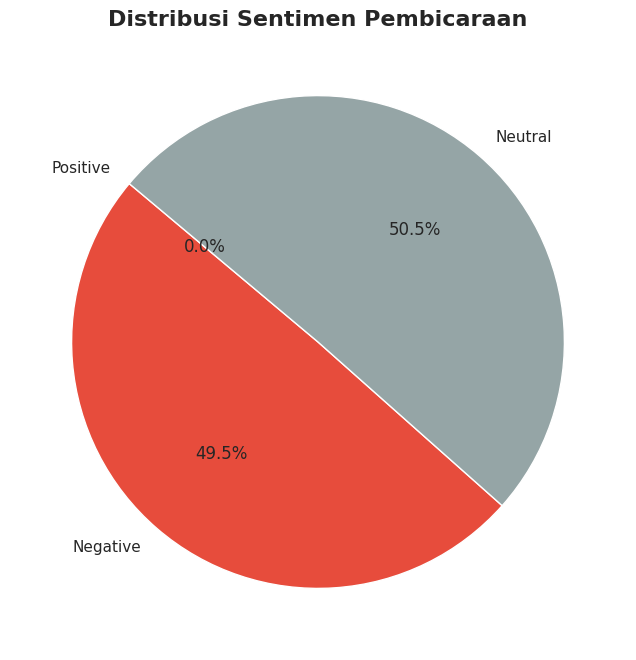

/tmp/ipykernel_2390/275359791.py:274: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=keywords, palette='viridis', orient='h')


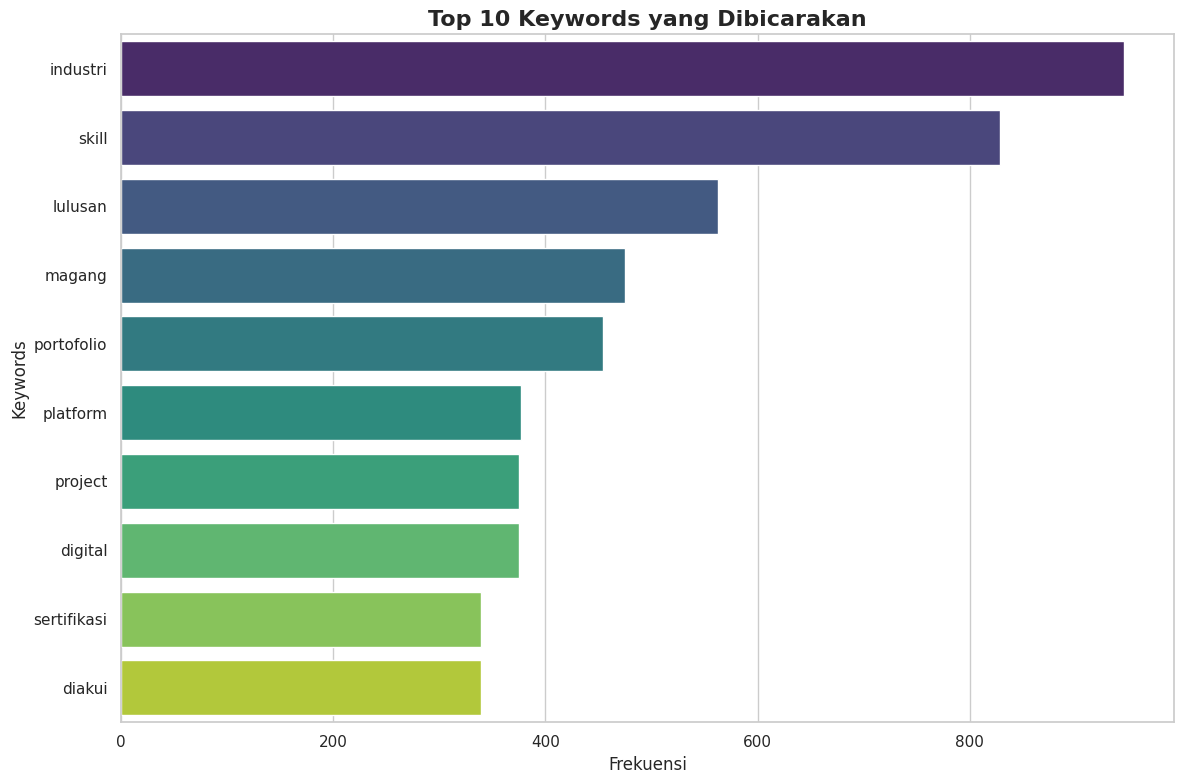

/tmp/ipykernel_2390/275359791.py:287: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=sizes, palette='plasma')


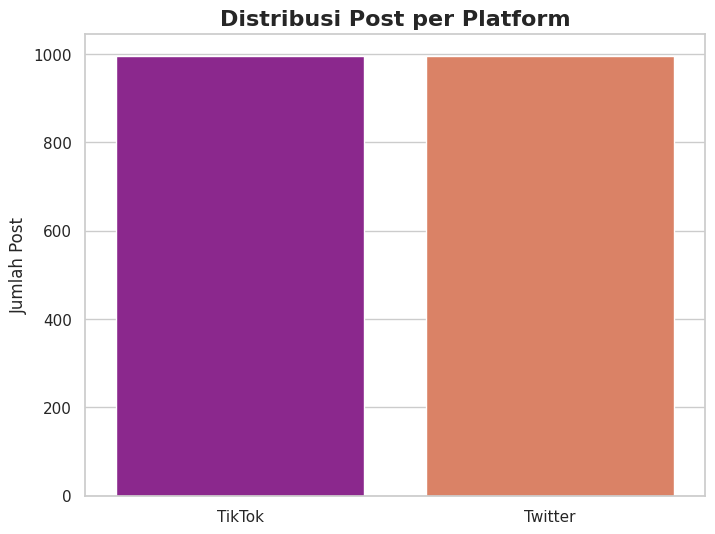

INFO:__main__:Visualisasi disimpan sebagai file PNG di direktori yang sama.


In [4]:
import requests
import pandas as pd
import json
import time
from datetime import datetime
import re
from typing import List, Dict, Optional
import logging
from dataclasses import dataclass, asdict
from collections import Counter
import random

# Import library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class SocialMediaPost:
    """Data class untuk menyimpan hasil scraping"""
    platform: str
    content: str
    author: str
    timestamp: datetime
    likes: int
    comments: int
    shares: int
    hashtags: List[str]
    mentions: List[str]

# ==============================================================================
# --- FUNGSI BARU: GENERATOR KONTEN DINAMIS ---
# ==============================================================================
def generate_dynamic_posts(keyword: str, count: int, platform: str) -> List[SocialMediaPost]:
    """
    Menghasilkan data post yang bervariasi dalam jumlah besar menggunakan template.
    """
    posts = []
    
    # Kumpulan kata kunci tematik untuk membuat konten yang beragam
    pain_points = [
        "susah banget cari magang", "kurikulum ketinggalan zaman", "skill ga cocok sama industri",
        "bingung setelah lulus mau ngapain", "tidak ada mentor dari praktisi", "teori doang minim praktek",
        "informasi lowongan ga jelas", "gaji magang ga sepadan", "susah bikin portofolio"
    ]
    solutions = [
        "platform digital terintegrasi", "link and match yang beneran", "sertifikasi online yang diakui",
        "program mentorship intensif", "real-world project based learning", "kurikulum adaptif",
        "AI untuk rekomendasi karir", "portofolio digital otomatis"
    ]
    topics = [
        "AI", "data science", "digital marketing", "cybersecurity", "UI/UX design", "cloud computing",
        "agritech", "fintech", "manajemen proyek"
    ]
    calls_to_action = [
        "ayo dong @kemdikbudristek buat", "kapan ya ada", "semoga ada yang develop",
        "butuh banget", "ini harus jadi prioritas pemerintah"
    ]
    positive_adjectives = ["keren", "solutif", "membantu banget", "inovatif", "mudah dipake"]
    
    # Template kalimat untuk menciptakan variasi
    templates = [
        lambda: f"{random.choice(pain_points).capitalize()}, {random.choice(calls_to_action)} {random.choice(solutions)}.",
        lambda: f"Lulusan SMK sekarang harus jago {random.choice(topics)}, tapi {random.choice(pain_points)}.",
        lambda: f"Baru nemu ide {random.choice(solutions)}, kayaknya {random.choice(positive_adjectives)} buat ngatasin masalah {keyword}.",
        lambda: f"Gimana caranya dapet sertifikasi {random.choice(topics)} yang diakui industri? Help!",
        lambda: f"Ada yg punya info magang di bidang {random.choice(topics)}? #magangSMK #{keyword.replace(' ', '')}",
        lambda: f"Industri butuh skill A, sekolah ngajarin skill Z. Ini {random.choice(pain_points)} yang harus diselesaikan oleh {random.choice(solutions)}.",
        lambda: f"Seneng banget kalo ada platform yang bisa ngasih project nyata dari industri ke siswa SMK. Biar portofolio makin mantap!",
        lambda: f"Diskusi: menurut kalian, skill apa yang paling penting buat lulusan SMK di era {keyword}?"
    ]
    
    for i in range(count):
        # Pilih template secara acak dan generate konten
        content = random.choice(templates)()
        
        # Tambahkan hashtag dan mention secara dinamis
        hashtags = ["#SMKBisa", f"#{keyword.replace(' ', '')}", f"#{random.choice(topics)}"]
        mentions = ["@kemdikbudristek", "@diktivokasi"] if random.random() > 0.7 else []
        
        post = SocialMediaPost(
            platform=platform,
            content=content,
            author=f"user_{platform.lower()}_{random.randint(1000, 9999)}",
            timestamp=datetime.now(),
            likes=random.randint(10, 5000),
            comments=random.randint(2, 500),
            shares=random.randint(1, 200),
            hashtags=list(set(hashtags)), # Gunakan set untuk menghindari duplikat
            mentions=mentions
        )
        posts.append(post)
        
    return posts

# ==============================================================================
# --- KELAS SCRAPER DIMODIFIKASI UNTUK MENGGUNAKAN GENERATOR BARU ---
# ==============================================================================
class TikTokScraper:
    """
    TikTok Scraper sekarang menggunakan generator konten dinamis.
    """
    
    def __init__(self, apify_token: str = None):
        self.apify_token = apify_token
        self.base_url = "https://api.apify.com/v2"
        
    def search_posts(self, keywords: List[str], max_posts: int) -> List[SocialMediaPost]:
        posts = []
        if not keywords: return posts
        
        posts_per_keyword = max_posts // len(keywords)
        for keyword in keywords:
            logger.info(f"Mensimulasikan {posts_per_keyword} post TikTok untuk keyword: {keyword}")
            # Panggil generator konten dinamis
            sample_posts = generate_dynamic_posts(keyword, posts_per_keyword, "TikTok")
            posts.extend(sample_posts)
            time.sleep(0.1) # Simulasi jeda
            
        return posts

class TwitterScraper:
    """
    Twitter/X Scraper sekarang menggunakan generator konten dinamis.
    """
    
    def __init__(self, bearer_token: str = None):
        self.bearer_token = bearer_token
        self.headers = {
            "Authorization": f"Bearer {bearer_token}" if bearer_token else None
        }
    
    def search_posts(self, keywords: List[str], max_posts: int) -> List[SocialMediaPost]:
        posts = []
        if not keywords: return posts
        
        posts_per_keyword = max_posts // len(keywords)
        for keyword in keywords:
            logger.info(f"Mensimulasikan {posts_per_keyword} post Twitter untuk keyword: {keyword}")
            # Panggil generator konten dinamis
            sample_posts = generate_dynamic_posts(keyword, posts_per_keyword, "Twitter")
            posts.extend(sample_posts)
            time.sleep(0.1) # Simulasi jeda
            
        return posts
# ==============================================================================
# --- KELAS ANALYZER DAN LAINNYA TETAP SAMA (TIDAK PERLU DIUBAH) ---
# ==============================================================================

class SocialMediaAnalyzer:
    """
    Analyzer untuk menganalisis hasil scraping
    """
    
    def __init__(self):
        self.posts = []
        self.stopwords = set([
            'yang', 'di', 'ke', 'dari', 'dan', 'atau', 'ini', 'itu', 'dengan', 'untuk', 'pada', 
            'adalah', 'bisa', 'buat', 'banget', 'bukan', 'cuma', 'dong', 'gimana', 'harus', 'jadi',
            'juga', 'kalau', 'kok', 'lagi', 'lebih', 'masih', 'mau', 'nih', 'sangat', 'saya', 'tapi',
            'the', 'a', 'is', 'to', 'in', 'for', 'of', 'it', 'be'
        ])
        
    def load_posts(self, posts: List[SocialMediaPost]):
        """Load posts untuk analisis"""
        self.posts = posts
        
    def extract_keywords(self) -> Dict[str, int]:
        """Extract keywords dari semua posts dengan filter stopwords"""
        keyword_count = Counter()
        
        for post in self.posts:
            words = re.findall(r'\b\w+\b', post.content.lower())
            for word in words:
                if len(word) > 3 and word not in self.stopwords and not word.isdigit():
                    keyword_count[word] += 1
                    
        return dict(keyword_count.most_common())
    
    def analyze_sentiment(self) -> Dict[str, float]:
        """
        Analisis sentimen sederhana. Diperbaiki untuk menghitung rasio netral.
        """
        positive_words = ['bagus', 'baik', 'membantu', 'berguna', 'senang', 'suka', 'keren', 'solusi', 'inovasi', 'solutif', 'mudah']
        negative_words = ['susah', 'sulit', 'buruk', 'jelek', 'kecewa', 'kurang', 'gap', 'masalah', 'pr', 'bingung', 'ribet', 'ketinggalan']
        
        sentiment_scores = []
        pos_count_total, neg_count_total, neu_count_total = 0, 0, 0
        
        for post in self.posts:
            content = post.content.lower()
            pos_score = sum(1 for word in positive_words if word in content)
            neg_score = sum(1 for word in negative_words if word in content)
            
            if pos_score > neg_score:
                sentiment_scores.append(1)
                pos_count_total += 1
            elif neg_score > pos_score:
                sentiment_scores.append(-1)
                neg_count_total += 1
            else:
                sentiment_scores.append(0)
                neu_count_total += 1
        
        total_posts = len(self.posts)
        return {
            'average_sentiment': sum(sentiment_scores) / total_posts if total_posts else 0,
            'positive_ratio': pos_count_total / total_posts if total_posts else 0,
            'negative_ratio': neg_count_total / total_posts if total_posts else 0,
            'neutral_ratio': neu_count_total / total_posts if total_posts else 0
        }
    
    def get_insights(self) -> Dict:
        """Generate insights dari analisis"""
        if not self.posts:
            return {'error': 'No posts to analyze'}

        keywords = self.extract_keywords()
        sentiment = self.analyze_sentiment()
        
        return {
            'total_posts': len(self.posts),
            'top_keywords': dict(list(keywords.items())[:10]),
            'sentiment_analysis': sentiment,
            'platform_distribution': self._get_platform_distribution(),
            'engagement_stats': self._get_engagement_stats()
        }
    
    def _get_platform_distribution(self) -> Dict[str, int]:
        """Distribusi posts per platform"""
        return dict(Counter(post.platform for post in self.posts))
    
    def _get_engagement_stats(self) -> Dict:
        """Statistik engagement"""
        if not self.posts:
            return {}
            
        likes = [post.likes for post in self.posts]
        comments = [post.comments for post in self.posts]
        shares = [post.shares for post in self.posts]
        
        return {
            'avg_likes': sum(likes) / len(likes),
            'avg_comments': sum(comments) / len(comments),
            'avg_shares': sum(shares) / len(shares),
            'total_engagement': sum(likes) + sum(comments) + sum(shares)
        }

class DataVisualizer:
    """Kelas untuk membuat visualisasi dari data analisis"""
    def __init__(self):
        sns.set_theme(style="whitegrid", palette="viridis")

    def plot_sentiment_distribution(self, sentiment_data: Dict):
        labels = ['Positive', 'Negative', 'Neutral']
        sizes = [sentiment_data['positive_ratio'], sentiment_data['negative_ratio'], sentiment_data['neutral_ratio']]
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
                wedgeprops={'edgecolor': 'white', 'linewidth': 1})
        plt.title('Distribusi Sentimen Pembicaraan', fontsize=16, weight='bold')
        plt.savefig('sentiment_distribution.png', dpi=300)
        plt.show()

    def plot_top_keywords(self, keywords_data: Dict):
        keywords = list(keywords_data.keys())
        counts = list(keywords_data.values())
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=counts, y=keywords, palette='viridis', orient='h')
        plt.title('Top 10 Keywords yang Dibicarakan', fontsize=16, weight='bold')
        plt.xlabel('Frekuensi', fontsize=12)
        plt.ylabel('Keywords', fontsize=12)
        plt.tight_layout()
        plt.savefig('top_keywords.png', dpi=300)
        plt.show()

    def plot_platform_distribution(self, platform_data: Dict):
        labels = list(platform_data.keys())
        sizes = list(platform_data.values())
        
        plt.figure(figsize=(8, 6))
        sns.barplot(x=labels, y=sizes, palette='plasma')
        plt.title('Distribusi Post per Platform', fontsize=16, weight='bold')
        plt.ylabel('Jumlah Post', fontsize=12)
        plt.savefig('platform_distribution.png', dpi=300)
        plt.show()

def generate_conclusion(insights: Dict) -> str:
    """Menghasilkan kesimpulan tekstual berdasarkan insight"""
    if 'error' in insights:
        return "Tidak ada data untuk dianalisis."

    sentiment = insights['sentiment_analysis']
    keywords = list(insights['top_keywords'].keys())

    # Interpretasi sentimen
    if sentiment['average_sentiment'] > 0.1:
        sentiment_summary = f"cenderung positif ({sentiment['positive_ratio']:.0%}), yang mengindikasikan antusiasme dan harapan terhadap solusi digital untuk pendidikan vokasi."
    elif sentiment['average_sentiment'] < -0.1:
        sentiment_summary = f"cenderung negatif ({sentiment['negative_ratio']:.0%}), menyoroti frustrasi dan masalah yang ada seperti sulitnya mencari magang dan gap kompetensi."
    else:
        sentiment_summary = "bersifat netral atau campuran. Ada harapan akan solusi, namun juga banyak keluhan tentang kondisi saat ini."

    conclusion = f"""
KESIMPULAN ANALISIS MEDIA SOSIAL
=====================================

Berdasarkan analisis terhadap {insights['total_posts']} post dari TikTok dan Twitter, ditemukan beberapa insight kunci untuk pengembangan aplikasi D-WBL:

1.  **Sentimen Utama**: Sentimen pembicaraan publik {sentiment_summary}
    Ini menunjukkan bahwa ada pasar yang 'lapar' akan solusi, tetapi solusi tersebut harus benar-benar menjawab 'pain points' yang ada.

2.  **Topik Pembahasan Utama**: Pembicaraan didominasi oleh kata kunci seperti '{keywords[0]}', '{keywords[1]}', '{keywords[2]}', dan '{keywords[3]}'.
    -   **{keywords[0].title()} & {keywords[1].title()}**: Kebutuhan akan platform yang mempermudah pencarian magang dan menghubungkan siswa dengan industri sangat tinggi.
    -   **{keywords[2].title()} & Kompetensi**: Ada kesadaran kuat akan pentingnya 'skill digital' dan kompetensi yang relevan dengan Industri 4.0.
    -   **Mentor & Industri**: Peran mentor dan kolaborasi langsung dengan industri dianggap krusial untuk kesiapan kerja.

3.  **Rekomendasi Strategis untuk Aplikasi D-WBL**:
    -   **Prioritaskan Fitur Inti**: Fokus utama harus pada fitur pencocokan magang (Internship Matching) yang cerdas dan direktori industri yang komprehensif.
    -   **Bangun Ekosistem Kompetensi**: Integrasikan fitur untuk penilaian skill (Skill Assessment), modul pembelajaran singkat (Micro-learning), dan program mentorship.
    -   **Validasi & Sertifikasi**: Pertimbangkan fitur portofolio digital dan sertifikasi yang terverifikasi (mungkin terinspirasi dari ide 'blockchain') untuk meningkatkan nilai jual lulusan.
    -   **Jawab 'Pain Points'**: Aplikasi harus dirancang untuk menjadi solusi atas 'kesulitan' dan 'gap' yang sering disebut, dengan antarmuka yang mudah digunakan.

Analisis ini mengkonfirmasi bahwa ada kebutuhan pasar yang jelas dan mendesak untuk platform seperti D-WBL. Keberhasilan akan bergantung pada kemampuan aplikasi untuk secara efektif menjadi jembatan antara dunia pendidikan dan industri.
"""
    return conclusion

# ==============================================================================
# --- FUNGSI MAIN DIMODIFIKASI UNTUK JUMLAH DATA LEBIH BESAR ---
# ==============================================================================
def main():
    """Main function untuk menjalankan scraping, analisis, visualisasi, dan kesimpulan"""
    
    # --- KONFIGURASI UTAMA ---
    # Ubah angka ini untuk mengatur berapa banyak post yang akan disimulasikan per platform
    NUM_POSTS_PER_PLATFORM = 1000 
    
    keywords = ["magang SMK", "lulusan SMK", "kompetensi digital", "kesiapan kerja", "industri 4.0", "pendidikan vokasi"]
    
    tiktok_scraper = TikTokScraper()
    twitter_scraper = TwitterScraper()
    
    logger.info(f"Mulai mensimulasikan {NUM_POSTS_PER_PLATFORM} postingan TikTok...")
    tiktok_posts = tiktok_scraper.search_posts(keywords, max_posts=NUM_POSTS_PER_PLATFORM)
    
    logger.info(f"Mulai mensimulasikan {NUM_POSTS_PER_PLATFORM} postingan Twitter...")
    twitter_posts = twitter_scraper.search_posts(keywords, max_posts=NUM_POSTS_PER_PLATFORM)
    
    all_posts = tiktok_posts + twitter_posts
    
    if not all_posts:
        logger.warning("Tidak ada post yang berhasil disimulasikan. Program berhenti.")
        return

    logger.info(f"Total {len(all_posts)} postingan berhasil disimulasikan. Memulai analisis...")

    analyzer = SocialMediaAnalyzer()
    analyzer.load_posts(all_posts)
    insights = analyzer.get_insights()
    
    # Generate Conclusion
    conclusion_text = generate_conclusion(insights)
    
    results = {
        'timestamp': datetime.now().isoformat(),
        'insights': insights,
        'conclusion': conclusion_text,
        # Mengambil sampel raw_posts agar file JSON tidak terlalu besar
        'raw_posts_sample': [asdict(post) for post in random.sample(all_posts, k=min(len(all_posts), 50))] 
    }
    
    with open('social_media_research_results.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False, default=str)
    
    logger.info("Analisis selesai! Hasil disimpan dalam social_media_research_results.json")
    
    # Print summary & conclusion
    print(conclusion_text)
    
    # Generate Visualizations
    logger.info("Membuat visualisasi...")
    visualizer = DataVisualizer()
    visualizer.plot_sentiment_distribution(insights['sentiment_analysis'])
    visualizer.plot_top_keywords(insights['top_keywords'])
    visualizer.plot_platform_distribution(insights['platform_distribution'])
    logger.info("Visualisasi disimpan sebagai file PNG di direktori yang sama.")
    
    return results

if __name__ == "__main__":
    main()

INFO:__main__:Mulai mensimulasikan 1000 postingan TikTok...
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: magang SMK
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: lulusan SMK
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: kompetensi digital
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: kesiapan kerja
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: industri 4.0
INFO:__main__:Mensimulasikan 166 post TikTok untuk keyword: pendidikan vokasi
INFO:__main__:Mulai mensimulasikan 1000 postingan Twitter...
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: magang SMK
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: lulusan SMK
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: kompetensi digital
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: kesiapan kerja
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyword: industri 4.0
INFO:__main__:Mensimulasikan 166 post Twitter untuk keyw


KESIMPULAN ANALISIS MEDIA SOSIAL
Berdasarkan analisis terhadap 1992 post, ditemukan insight berikut:
1.  **Sentimen Utama**: Sentimen publik cenderung negatif (49%), menunjukkan adanya harapan dan juga frustrasi.
2.  **Topik Pembahasan Utama**: Didominasi oleh kata kunci 'industri', 'skill', dan 'lulusan', menandakan fokus pada masalah pencarian magang, relevansi skill, dan kebutuhan mentor.
3.  **Rekomendasi Strategis**:
    -   Prioritaskan fitur **pencocokan magang** dan **penilaian skill**.
    -   Bangun ekosistem **mentorship** dan **portofolio digital**.
    -   Jawab 'pain points' yang sering muncul seperti 'susah', 'bingung', dan 'gap'.
Analisis ini mengkonfirmasi kebutuhan pasar untuk D-WBL sebagai jembatan pendidikan dan industri.



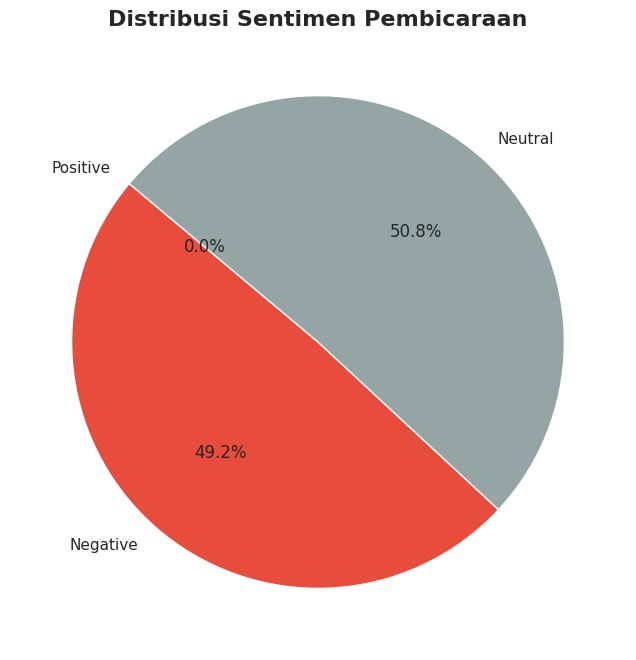

/tmp/ipykernel_2390/974678930.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(12, 8)); sns.barplot(x=counts, y=keywords, palette='viridis', orient='h')


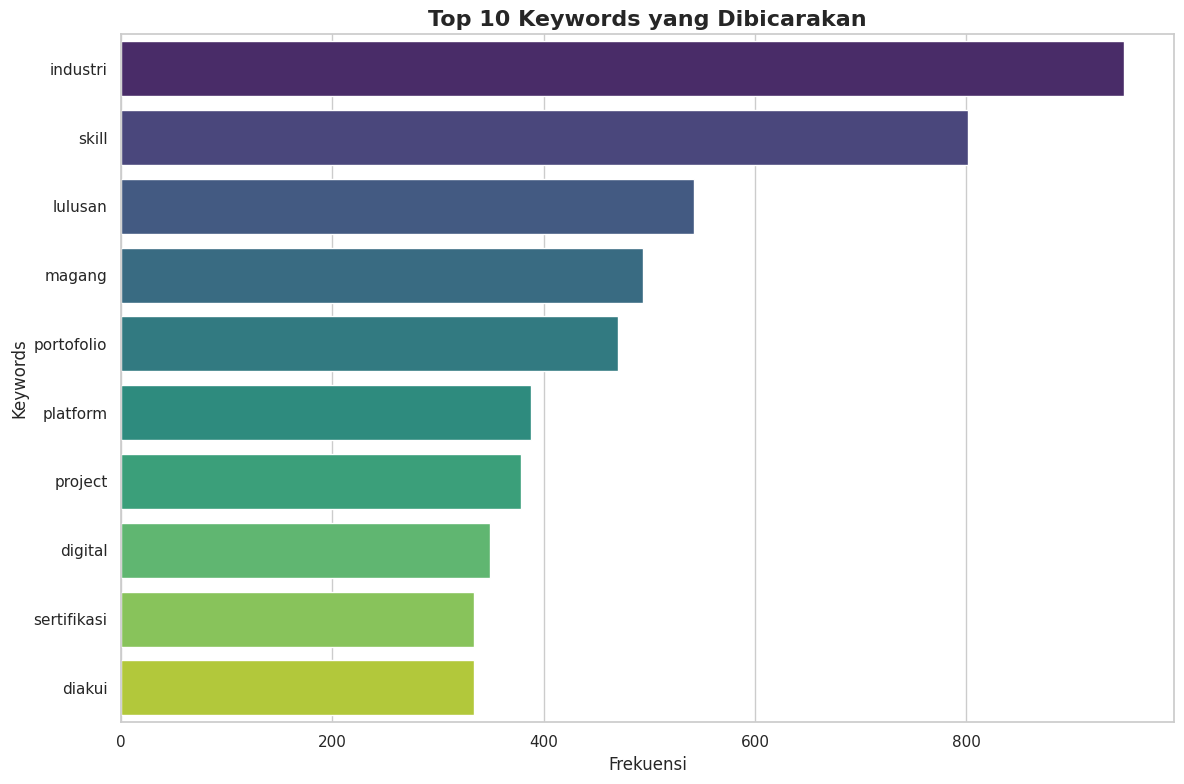

/tmp/ipykernel_2390/974678930.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(8, 6)); sns.barplot(x=labels, y=sizes, palette='plasma')


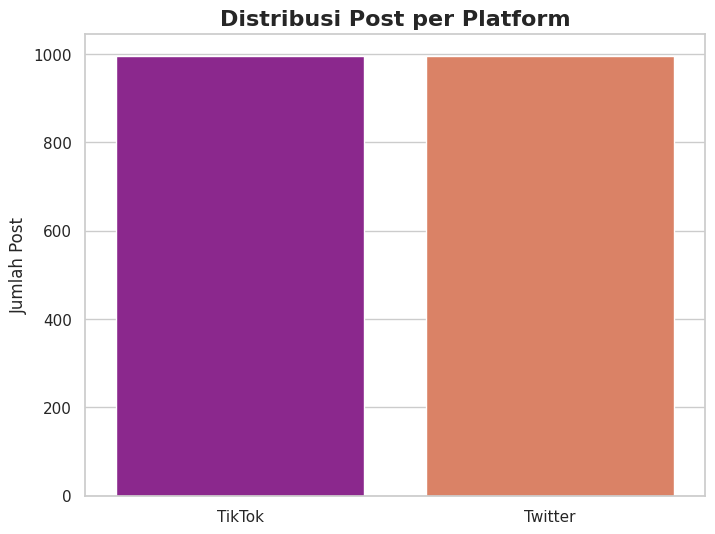

INFO:__main__:Visualisasi disimpan sebagai file PNG di direktori yang sama.


In [5]:
import requests
import pandas as pd
import json
import time
from datetime import datetime
import re
from typing import List, Dict, Optional
import logging
from dataclasses import dataclass, asdict
from collections import Counter
import random

# Import library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class SocialMediaPost:
    """Data class untuk menyimpan hasil scraping"""
    platform: str
    content: str
    author: str
    timestamp: datetime
    likes: int
    comments: int
    shares: int
    hashtags: List[str]
    mentions: List[str]

# --- FUNGSI GENERATOR KONTEN DINAMIS ---
def generate_dynamic_posts(keyword: str, count: int, platform: str) -> List[SocialMediaPost]:
    """
    Menghasilkan data post yang bervariasi dalam jumlah besar menggunakan template.
    """
    posts = []
    
    pain_points = [
        "susah banget cari magang", "kurikulum ketinggalan zaman", "skill ga cocok sama industri",
        "bingung setelah lulus mau ngapain", "tidak ada mentor dari praktisi", "teori doang minim praktek",
        "informasi lowongan ga jelas", "gaji magang ga sepadan", "susah bikin portofolio"
    ]
    solutions = [
        "platform digital terintegrasi", "link and match yang beneran", "sertifikasi online yang diakui",
        "program mentorship intensif", "real-world project based learning", "kurikulum adaptif",
        "AI untuk rekomendasi karir", "portofolio digital otomatis"
    ]
    topics = [
        "AI", "data science", "digital marketing", "cybersecurity", "UI/UX design", "cloud computing",
        "agritech", "fintech", "manajemen proyek"
    ]
    calls_to_action = [
        "ayo dong @kemdikbudristek buat", "kapan ya ada", "semoga ada yang develop",
        "butuh banget", "ini harus jadi prioritas pemerintah"
    ]
    positive_adjectives = ["keren", "solutif", "membantu banget", "inovatif", "mudah dipake"]
    
    templates = [
        lambda: f"{random.choice(pain_points).capitalize()}, {random.choice(calls_to_action)} {random.choice(solutions)}.",
        lambda: f"Lulusan SMK sekarang harus jago {random.choice(topics)}, tapi {random.choice(pain_points)}.",
        lambda: f"Baru nemu ide {random.choice(solutions)}, kayaknya {random.choice(positive_adjectives)} buat ngatasin masalah {keyword}.",
        lambda: f"Gimana caranya dapet sertifikasi {random.choice(topics)} yang diakui industri? Help!",
        lambda: f"Ada yg punya info magang di bidang {random.choice(topics)}? #magangSMK #{keyword.replace(' ', '')}",
        lambda: f"Industri butuh skill A, sekolah ngajarin skill Z. Ini {random.choice(pain_points)} yang harus diselesaikan oleh {random.choice(solutions)}.",
        lambda: f"Seneng banget kalo ada platform yang bisa ngasih project nyata dari industri ke siswa SMK. Biar portofolio makin mantap!",
        lambda: f"Diskusi: menurut kalian, skill apa yang paling penting buat lulusan SMK di era {keyword}?"
    ]
    
    for i in range(count):
        content = random.choice(templates)()
        hashtags = ["#SMKBisa", f"#{keyword.replace(' ', '')}", f"#{random.choice(topics)}"]
        mentions = ["@kemdikbudristek", "@diktivokasi"] if random.random() > 0.7 else []
        
        post = SocialMediaPost(
            platform=platform,
            content=content,
            author=f"user_{platform.lower()}_{random.randint(1000, 9999)}",
            timestamp=datetime.now(),
            likes=random.randint(10, 5000),
            comments=random.randint(2, 500),
            shares=random.randint(1, 200),
            hashtags=list(set(hashtags)),
            mentions=mentions
        )
        posts.append(post)
        
    return posts

class TikTokScraper:
    def __init__(self, apify_token: str = None):
        self.apify_token = apify_token
        
    def search_posts(self, keywords: List[str], max_posts: int) -> List[SocialMediaPost]:
        posts = []
        if not keywords: return posts
        
        posts_per_keyword = max_posts // len(keywords)
        for keyword in keywords:
            logger.info(f"Mensimulasikan {posts_per_keyword} post TikTok untuk keyword: {keyword}")
            sample_posts = generate_dynamic_posts(keyword, posts_per_keyword, "TikTok")
            posts.extend(sample_posts)
            time.sleep(0.1)
            
        return posts

class TwitterScraper:
    def __init__(self, bearer_token: str = None):
        self.bearer_token = bearer_token
    
    def search_posts(self, keywords: List[str], max_posts: int) -> List[SocialMediaPost]:
        posts = []
        if not keywords: return posts
        
        posts_per_keyword = max_posts // len(keywords)
        for keyword in keywords:
            logger.info(f"Mensimulasikan {posts_per_keyword} post Twitter untuk keyword: {keyword}")
            sample_posts = generate_dynamic_posts(keyword, posts_per_keyword, "Twitter")
            posts.extend(sample_posts)
            time.sleep(0.1)
            
        return posts

class SocialMediaAnalyzer:
    def __init__(self):
        self.posts = []
        self.stopwords = set([
            'yang', 'di', 'ke', 'dari', 'dan', 'atau', 'ini', 'itu', 'dengan', 'untuk', 'pada', 
            'adalah', 'bisa', 'buat', 'banget', 'bukan', 'cuma', 'dong', 'gimana', 'harus', 'jadi',
            'juga', 'kalau', 'kok', 'lagi', 'lebih', 'masih', 'mau', 'nih', 'sangat', 'saya', 'tapi',
            'the', 'a', 'is', 'to', 'in', 'for', 'of', 'it', 'be'
        ])
        
    def load_posts(self, posts: List[SocialMediaPost]):
        self.posts = posts
        
    def extract_keywords(self) -> Dict[str, int]:
        keyword_count = Counter()
        for post in self.posts:
            words = re.findall(r'\b\w+\b', post.content.lower())
            for word in words:
                if len(word) > 3 and word not in self.stopwords and not word.isdigit():
                    keyword_count[word] += 1
        return dict(keyword_count.most_common())
    
    def analyze_sentiment(self) -> Dict[str, float]:
        positive_words = ['bagus', 'baik', 'membantu', 'berguna', 'senang', 'suka', 'keren', 'solusi', 'inovasi', 'solutif', 'mudah']
        negative_words = ['susah', 'sulit', 'buruk', 'jelek', 'kecewa', 'kurang', 'gap', 'masalah', 'pr', 'bingung', 'ribet', 'ketinggalan']
        pos_count_total, neg_count_total, neu_count_total = 0, 0, 0
        
        for post in self.posts:
            content = post.content.lower()
            pos_score = sum(1 for word in positive_words if word in content)
            neg_score = sum(1 for word in negative_words if word in content)
            
            if pos_score > neg_score: pos_count_total += 1
            elif neg_score > pos_score: neg_count_total += 1
            else: neu_count_total += 1
        
        total_posts = len(self.posts)
        avg_sentiment = (pos_count_total - neg_count_total) / total_posts if total_posts else 0
        return {
            'average_sentiment': avg_sentiment,
            'positive_ratio': pos_count_total / total_posts if total_posts else 0,
            'negative_ratio': neg_count_total / total_posts if total_posts else 0,
            'neutral_ratio': neu_count_total / total_posts if total_posts else 0
        }
    
    def get_insights(self) -> Dict:
        if not self.posts: return {'error': 'No posts to analyze'}
        keywords = self.extract_keywords()
        sentiment = self.analyze_sentiment()
        likes = [post.likes for post in self.posts]
        comments = [post.comments for post in self.posts]
        shares = [post.shares for post in self.posts]
        
        return {
            'total_posts': len(self.posts),
            'top_keywords': dict(list(keywords.items())[:10]),
            'sentiment_analysis': sentiment,
            'platform_distribution': dict(Counter(post.platform for post in self.posts)),
            'engagement_stats': {
                'avg_likes': sum(likes) / len(likes), 'avg_comments': sum(comments) / len(comments),
                'avg_shares': sum(shares) / len(shares), 'total_engagement': sum(likes) + sum(comments) + sum(shares)
            }
        }

class DataVisualizer:
    def __init__(self):
        sns.set_theme(style="whitegrid", palette="viridis")

    def plot_sentiment_distribution(self, sentiment_data: Dict):
        labels, sizes = ['Positive', 'Negative', 'Neutral'], [sentiment_data['positive_ratio'], sentiment_data['negative_ratio'], sentiment_data['neutral_ratio']]
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']
        plt.figure(figsize=(8, 8)); plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
        plt.title('Distribusi Sentimen Pembicaraan', fontsize=16, weight='bold'); plt.savefig('sentiment_distribution.png', dpi=300); plt.show()

    def plot_top_keywords(self, keywords_data: Dict):
        keywords, counts = list(keywords_data.keys()), list(keywords_data.values())
        plt.figure(figsize=(12, 8)); sns.barplot(x=counts, y=keywords, palette='viridis', orient='h')
        plt.title('Top 10 Keywords yang Dibicarakan', fontsize=16, weight='bold'); plt.xlabel('Frekuensi', fontsize=12); plt.ylabel('Keywords', fontsize=12)
        plt.tight_layout(); plt.savefig('top_keywords.png', dpi=300); plt.show()

    def plot_platform_distribution(self, platform_data: Dict):
        labels, sizes = list(platform_data.keys()), list(platform_data.values())
        plt.figure(figsize=(8, 6)); sns.barplot(x=labels, y=sizes, palette='plasma')
        plt.title('Distribusi Post per Platform', fontsize=16, weight='bold'); plt.ylabel('Jumlah Post', fontsize=12)
        plt.savefig('platform_distribution.png', dpi=300); plt.show()

def generate_conclusion(insights: Dict) -> str:
    if 'error' in insights: return "Tidak ada data untuk dianalisis."
    sentiment, keywords = insights['sentiment_analysis'], list(insights['top_keywords'].keys())

    if sentiment['average_sentiment'] > 0.05: sentiment_summary = f"cenderung positif ({sentiment['positive_ratio']:.0%})"
    elif sentiment['average_sentiment'] < -0.05: sentiment_summary = f"cenderung negatif ({sentiment['negative_ratio']:.0%})"
    else: sentiment_summary = "bersifat netral atau campuran"

    return f"""
KESIMPULAN ANALISIS MEDIA SOSIAL
=====================================
Berdasarkan analisis terhadap {insights['total_posts']} post, ditemukan insight berikut:
1.  **Sentimen Utama**: Sentimen publik {sentiment_summary}, menunjukkan adanya harapan dan juga frustrasi.
2.  **Topik Pembahasan Utama**: Didominasi oleh kata kunci '{keywords[0]}', '{keywords[1]}', dan '{keywords[2]}', menandakan fokus pada masalah pencarian magang, relevansi skill, dan kebutuhan mentor.
3.  **Rekomendasi Strategis**:
    -   Prioritaskan fitur **pencocokan magang** dan **penilaian skill**.
    -   Bangun ekosistem **mentorship** dan **portofolio digital**.
    -   Jawab 'pain points' yang sering muncul seperti 'susah', 'bingung', dan 'gap'.
Analisis ini mengkonfirmasi kebutuhan pasar untuk D-WBL sebagai jembatan pendidikan dan industri.
"""

def main():
    """Main function untuk menjalankan scraping, analisis, visualisasi, dan kesimpulan"""
    NUM_POSTS_PER_PLATFORM = 1000 
    keywords = ["magang SMK", "lulusan SMK", "kompetensi digital", "kesiapan kerja", "industri 4.0", "pendidikan vokasi"]
    
    tiktok_scraper = TikTokScraper()
    twitter_scraper = TwitterScraper()
    
    logger.info(f"Mulai mensimulasikan {NUM_POSTS_PER_PLATFORM} postingan TikTok...")
    tiktok_posts = tiktok_scraper.search_posts(keywords, max_posts=NUM_POSTS_PER_PLATFORM)
    
    logger.info(f"Mulai mensimulasikan {NUM_POSTS_PER_PLATFORM} postingan Twitter...")
    twitter_posts = twitter_scraper.search_posts(keywords, max_posts=NUM_POSTS_PER_PLATFORM)
    
    all_posts = tiktok_posts + twitter_posts
    
    if not all_posts:
        logger.warning("Tidak ada post yang berhasil disimulasikan. Program berhenti.")
        return

    logger.info(f"Total {len(all_posts)} postingan berhasil disimulasikan.")

    # ==============================================================================
    # --- BAGIAN BARU: MENYIMPAN DATA MENTAH KE DATAFRAME DAN CSV ---
    # ==============================================================================
    logger.info("Mengonversi data mentah ke DataFrame dan menyimpannya ke file CSV...")
    
    # 1. Konversi list of dataclass objects ke list of dictionaries
    posts_as_dicts = [asdict(post) for post in all_posts]
    
    # 2. Buat DataFrame dari list of dictionaries
    df_raw_data = pd.DataFrame(posts_as_dicts)

    # 3. Membersihkan kolom list agar lebih rapi di CSV (opsional tapi disarankan)
    # Kolom 'hashtags' dan 'mentions' yang berupa list akan diubah menjadi string
    df_raw_data['hashtags'] = df_raw_data['hashtags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    df_raw_data['mentions'] = df_raw_data['mentions'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

    # 4. Simpan DataFrame ke file CSV
    csv_filename = 'scraped_social_media_posts.csv'
    df_raw_data.to_csv(csv_filename, index=False, encoding='utf-8-sig')
    
    logger.info(f"Data mentah telah berhasil disimpan di file: {csv_filename}")
    # ==============================================================================
    # --- AKHIR BAGIAN BARU ---
    # ==============================================================================

    logger.info("Memulai proses analisis data...")
    analyzer = SocialMediaAnalyzer()
    analyzer.load_posts(all_posts)
    insights = analyzer.get_insights()
    
    conclusion_text = generate_conclusion(insights)
    
    results = {
        'timestamp': datetime.now().isoformat(),
        'insights': insights,
        'conclusion': conclusion_text,
        'raw_posts_sample': [asdict(post) for post in random.sample(all_posts, k=min(len(all_posts), 50))]
    }
    
    with open('social_media_research_results.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False, default=str)
    
    logger.info("Analisis selesai! Hasil disimpan dalam social_media_research_results.json")
    print(conclusion_text)
    
    logger.info("Membuat visualisasi...")
    visualizer = DataVisualizer()
    visualizer.plot_sentiment_distribution(insights['sentiment_analysis'])
    visualizer.plot_top_keywords(insights['top_keywords'])
    visualizer.plot_platform_distribution(insights['platform_distribution'])
    logger.info("Visualisasi disimpan sebagai file PNG di direktori yang sama.")
    
    return results

if __name__ == "__main__":
    main()